In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc

In [2]:
basedir = './국토교통부_건축물대장_표제부/'
filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv')) & (f.startswith('shared'))]
filenames

['shared_cols_bdinfo_2014.csv',
 'shared_cols_bdinfo_2015.csv',
 'shared_cols_bdinfo_2016.csv',
 'shared_cols_bdinfo_2017.csv',
 'shared_cols_bdinfo_2018.csv',
 'shared_cols_bdinfo_2019.csv',
 'shared_cols_bdinfo_2020.csv']

In [3]:
main_data_df = pd.read_csv('./prepped_data/main_data_ver_2.4.csv')
print(main_data_df.shape)
main_data_df.head()

(4559866, 16)


,지번주소,도로명주소,대장구분명,대장구분코드,trade_type,전용면적(㎡),금액(만원),월세(만원),가격/면적,층,년,월,건축년도,건물나이,target_log_transformed,target/area_log_transformed
0,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,일반,1,아파트_매매,77.75,57000,0,733.118971,2,2013,9,1988,25,10.950807,6.597308
1,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,일반,1,아파트_매매,77.75,57000,0,733.118971,2,2013,12,1988,25,10.950807,6.597308
2,서울특별시 강남구 개포동 658-1,서울특별시 강남구 언주로 3-0,일반,1,아파트_매매,67.28,55000,0,817.479191,5,2013,2,1987,26,10.915088,6.706225
3,서울특별시 강남구 개포동 658-1,서울특별시 강남구 언주로 3-0,일반,1,아파트_매매,67.28,58250,0,865.784780,4,2013,2,1987,26,10.972499,6.763636
4,서울특별시 강남구 개포동 658-1,서울특별시 강남구 언주로 3-0,일반,1,아파트_매매,67.28,60000,0,891.795482,5,2013,5,1987,26,11.002100,6.793237


In [4]:
def addr_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        splitted = x.split('-')
        if len(splitted) > 1:
            return x
        else:
            return x + '-0'

In [5]:
dfs_list = []
for f in tqdm(filenames):
    df = pd.read_csv(basedir + f)
    dfs_list.append(df)
concat_df = pd.concat(dfs_list)
print(concat_df.shape)
concat_df.head()

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]c:\users\max6296\ml\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (14,15,58,59) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
 14%|████████████                                                                        | 1/7 [00:03<00:18,  3.13s/it]c:\users\max6296\ml\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (13,14,15,34,58,59,67) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
 29%|████████████████████████                                                            | 2/7 [00:06<00:17,  3.46s/it]c:\users\max6296\ml\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (14,15,58,59,67) have mixed typ

(4367214, 75)


,관리_건축물대장_PK,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,도로명_대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,새주소_도로_코드,새주소_법정동_코드,새주소_지상지하_코드,새주소_본_번,새주소_부_번,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자
0,11305-10019310902,2,집합,3,표제부,서울특별시 강북구 수유동 484-80번지,서울특별시강북구 삼양로77가길 36,삼일교회,11305,10300.0,0.0,484.0,80.0,NaN,NaN,NaN,1,1.130541e+11,10301.0,0.0,36.0,0.0,삼일교회,0.0,주건축물,393.00,233.81,59.49,761.29,761.29,193.71,21.0,철근콘크리트구조,철근콘크리트구조(조적조(4층)),04000,제2종근린생활시설,"근린생활시설, 공동주택(다세대주택)",10.0,(철근)콘크리트,(철근)콘크리트(평스라브),3,0,12.2,4,0,0,0,0,0.0,761.29,0,0.0,0,0.0,0,0.00,7,80.50,20070821,20070829,20101216.0,2007,3080079.0,건축과,1101.0,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20101228
1,11440-2163902,2,집합,3,표제부,서울특별시 마포구 서교동 484-16번지,서울특별시마포구 양화로7길 61-10,NaN,11440,12000.0,0.0,484.0,16.0,NaN,NaN,NaN,0,1.144041e+11,12001.0,0.0,61.0,10.0,NaN,0.0,주건축물,177.62,105.30,59.28,393.13,385.21,216.87,21.0,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10.0,(철근)콘크리트,(철근)콘크리트 평스라브,4,0,12.0,4,1,0,0,0,0.0,393.13,0,0.0,0,0.0,0,0.00,4,46.00,20030628,20030820,20040323.0,2003,3130085.0,건축과,1101.0,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20101230
2,11200-2360202,1,일반,2,일반건축물,서울특별시 성동구 송정동 73-566번지,서울특별시성동구 송정14길 17,대한예수교장로회비전교회,11200,11800.0,0.0,73.0,566.0,NaN,NaN,NaN,0,1.120041e+11,11801.0,0.0,17.0,0.0,NaN,0.0,주건축물,806.00,376.05,46.66,1185.07,797.98,99.00,21.0,철근콘크리트구조,"철근콘크리트,철골조",06000,종교시설,교회,10.0,(철근)콘크리트,"슬라브,경량철골조",0,0,13.2,2,1,0,0,0,0.0,1185.07,0,0.0,0,0.0,0,0.00,0,0.00,NaN,NaN,19781205.0,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20110131
3,11380-2690602,1,일반,2,일반건축물,서울특별시 은평구 응암동 594-87번지,서울특별시은평구 응암로 163-13,NaN,11380,10700.0,0.0,594.0,87.0,NaN,NaN,NaN,0,1.138030e+11,10702.0,0.0,163.0,13.0,NaN,0.0,주건축물,0.00,0.00,0.00,246.15,0.00,0.00,11.0,벽돌구조,연와조,01000,단독주택,"단독주택,다가구용 (6가구)",10.0,(철근)콘크리트,슬라브,0,6,0.0,2,1,0,0,0,0.0,246.15,0,0.0,0,0.0,0,0.00,0,0.00,19900403,NaN,19911128.0,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20110105
4,11110-10017892502,1,일반,2,일반건축물,서울특별시 종로구 평창동 365-1번지,서울특별시종로구 평창11길 45,NaN,11110,18300.0,0.0,365.0,1.0,NaN,NaN,NaN,0,1.111041e+11,18301.0,0.0,45.0,0.0,NaN,0.0,주건축물,356.00,104.22,29.28,404.80,194.31,54.58,21.0,철근콘크리트구조,철근콘크리트구조,03000,제1종근린생활시설,제1종근린생활시설,10.0,(철근)콘크리트,(철근)콘크리트,0,0,7.9,2,1,0,0,0,0.0,404.80,0,0.0,0,0.0,1,33.29,2,40.19,20070605,20070616,20080319.0,2007,3000082.0,건축과,1101.0,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110101


In [6]:
concat_df['주소'] = concat_df['대지_위치'].str.replace('번지', '')
concat_df['주소'] = concat_df['주소'].apply(addr_modifier)
concat_df.head(1)

,관리_건축물대장_PK,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,도로명_대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,새주소_도로_코드,새주소_법정동_코드,새주소_지상지하_코드,새주소_본_번,새주소_부_번,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소
0,11305-10019310902,2,집합,3,표제부,서울특별시 강북구 수유동 484-80번지,서울특별시강북구 삼양로77가길 36,삼일교회,11305,10300.0,0.0,484.0,80.0,NaN,NaN,NaN,1,1.130541e+11,10301.0,0.0,36.0,0.0,삼일교회,0.0,주건축물,393.0,233.81,59.49,761.29,761.29,193.71,21.0,철근콘크리트구조,철근콘크리트구조(조적조(4층)),04000,제2종근린생활시설,"근린생활시설, 공동주택(다세대주택)",10.0,(철근)콘크리트,(철근)콘크리트(평스라브),3,0,12.2,4,0,0,0,0,0.0,761.29,0,0.0,0,0.0,0,0.0,7,80.5,20070821,20070829,20101216.0,2007,3080079.0,건축과,1101.0,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20101228,서울특별시 강북구 수유동 484-80


In [7]:
inter_df = concat_df[concat_df['주소'].isin(main_data_df['지번주소'].unique())]
print(inter_df.shape)
inter_df.head()

(954843, 76)


,관리_건축물대장_PK,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,도로명_대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,새주소_도로_코드,새주소_법정동_코드,새주소_지상지하_코드,새주소_본_번,새주소_부_번,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소
1,11440-2163902,2,집합,3,표제부,서울특별시 마포구 서교동 484-16번지,서울특별시마포구 양화로7길 61-10,NaN,11440,12000.0,0.0,484.0,16.0,NaN,NaN,NaN,0,1.144041e+11,12001.0,0.0,61.0,10.0,NaN,0.0,주건축물,177.62,105.300,59.28,393.130,385.210,216.87,21.0,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10.0,(철근)콘크리트,(철근)콘크리트 평스라브,4,0,12.00,4,1,0,0,0,0.0,393.130,0,0.0,0,0.0,0,0.00,4,46.0,20030628,20030820,20040323.0,2003,3130085.0,건축과,1101.0,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20101230,서울특별시 마포구 서교동 484-16
6,11590-10018266302,2,집합,3,표제부,서울특별시 동작구 상도동 302-28번지,서울특별시동작구 국사봉8길 64-17,두성쉐르빌,11590,10200.0,0.0,302.0,28.0,NaN,NaN,NaN,1,1.159042e+11,10201.0,0.0,64.0,17.0,NaN,0.0,주건축물,389.48,232.420,59.67,947.740,659.890,169.43,21.0,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10.0,(철근)콘크리트,(철근)콘크리트,10,0,11.26,4,1,0,0,0,0.0,947.740,0,0.0,0,0.0,8,287.85,2,11.5,20080404,20080405,20080826.0,2008,3190077.0,건축과,1101.0,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110119,서울특별시 동작구 상도동 302-28
7,11320-10018224102,2,집합,3,표제부,서울특별시 도봉구 쌍문동 380-24번지,서울특별시도봉구 노해로40길 25,NaN,11320,10500.0,0.0,380.0,24.0,NaN,NaN,NaN,0,1.132041e+11,10501.0,0.0,25.0,0.0,NaN,0.0,주건축물,208.00,81.085,38.98,268.165,268.165,128.93,21.0,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10.0,(철근)콘크리트,(철근)콘크리트,4,0,10.40,4,0,0,0,0,0.0,268.165,0,0.0,0,0.0,3,0.00,1,0.0,20080318,20080321,20080721.0,2008,3090077.0,건축과,1101.0,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110202,서울특별시 도봉구 쌍문동 380-24
8,11440-3217402,2,집합,3,표제부,서울특별시 마포구 성산동 200-260번지,서울특별시마포구 월드컵북로27길 29,대현하이빌,11440,12500.0,0.0,200.0,260.0,NaN,NaN,NaN,0,1.144041e+11,12501.0,0.0,29.0,0.0,NaN,0.0,주건축물,314.00,180.380,57.45,627.880,627.880,199.96,21.0,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10.0,(철근)콘크리트,평스라브,8,0,13.30,5,0,0,0,0,0.0,627.880,0,0.0,0,0.0,7,80.50,1,11.5,20050602,20050603,20050901.0,2005,NaN,NaN,1101.0,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110125,서울특별시 마포구 성산동 200-260
11,11740-10017967102,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,서울특별시강동구 아리수로93길 40,강일리버파크,11740,11000.0,0.0,674.0,0.0,NaN,NaN,NaN,0,1.174042e+11,11001.0,0.0,40.0,0.0,301동,0.0,주건축물,0.00,564.010,0.00,6401.190,6401.190,0.00,21.0,철근콘크리트구조,철근콘크리트구조,02000,공동주택,공동주택(아파트),10.0,(철근)콘크리트,(철근)콘크리트,78,0,45.60,14,0,3,0,0,0.0,6401.190,0,0.0,0,0.0,0,0.00,0,0.0,20041224,20060926,20090311.0,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20110122,서울특별시 강동구 강일동 674-0


In [8]:
inter_df['생성년도'] = inter_df['생성_일자'].apply(lambda x: int(str(x)[:4]))
inter_df.head(2)

,관리_건축물대장_PK,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,도로명_대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,새주소_도로_코드,새주소_법정동_코드,새주소_지상지하_코드,새주소_본_번,새주소_부_번,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도
1,11440-2163902,2,집합,3,표제부,서울특별시 마포구 서교동 484-16번지,서울특별시마포구 양화로7길 61-10,NaN,11440,12000.0,0.0,484.0,16.0,NaN,NaN,NaN,0,1.144041e+11,12001.0,0.0,61.0,10.0,NaN,0.0,주건축물,177.62,105.30,59.28,393.13,385.21,216.87,21.0,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10.0,(철근)콘크리트,(철근)콘크리트 평스라브,4,0,12.00,4,1,0,0,0,0.0,393.13,0,0.0,0,0.0,0,0.00,4,46.0,20030628,20030820,20040323.0,2003,3130085.0,건축과,1101.0,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20101230,서울특별시 마포구 서교동 484-16,2010
6,11590-10018266302,2,집합,3,표제부,서울특별시 동작구 상도동 302-28번지,서울특별시동작구 국사봉8길 64-17,두성쉐르빌,11590,10200.0,0.0,302.0,28.0,NaN,NaN,NaN,1,1.159042e+11,10201.0,0.0,64.0,17.0,NaN,0.0,주건축물,389.48,232.42,59.67,947.74,659.89,169.43,21.0,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10.0,(철근)콘크리트,(철근)콘크리트,10,0,11.26,4,1,0,0,0,0.0,947.74,0,0.0,0,0.0,8,287.85,2,11.5,20080404,20080405,20080826.0,2008,3190077.0,건축과,1101.0,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110119,서울특별시 동작구 상도동 302-28,2011


In [9]:
inter_df.drop(columns=['관리_건축물대장_PK', '도로명_대지_위치', '새주소_도로_코드', '새주소_법정동_코드'], inplace=True)

In [10]:
inter_df.drop(columns=[col for col in inter_df.columns.tolist() if '새주소' in col], inplace=True)

In [11]:
inter_df.drop_duplicates(inplace=True)
inter_df.shape

(730566, 70)

In [12]:
inter_df.head(1)

,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도
1,2,집합,3,표제부,서울특별시 마포구 서교동 484-16번지,NaN,11440,12000.0,0.0,484.0,16.0,NaN,NaN,NaN,0,NaN,0.0,주건축물,177.62,105.3,59.28,393.13,385.21,216.87,21.0,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10.0,(철근)콘크리트,(철근)콘크리트 평스라브,4,0,12.0,4,1,0,0,0,0.0,393.13,0,0.0,0,0.0,0,0.0,4,46.0,20030628,20030820,20040323.0,2003,3130085.0,건축과,1101.0,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20101230,서울특별시 마포구 서교동 484-16,2010


In [15]:
int_cols = [col for col in inter_df.columns if (('_수' in col) | ('_대수' in col) | ('_코드' in col) | ('_일' in col)) & ('명' not in col)]
int_cols

['대장_구분_코드',
 '대장_종류_코드',
 '시군구_코드',
 '법정동_코드',
 '대지_구분_코드',
 '외필지_수',
 '주_부속_구분_코드',
 '구조_코드',
 '주_용도_코드',
 '지붕_코드',
 '세대_수(세대)',
 '가구_수(가구)',
 '지상_층_수',
 '지하_층_수',
 '승용_승강기_수',
 '비상용_승강기_수',
 '부속_건축물_수',
 '옥내_기계식_대수(대)',
 '옥외_기계식_대수(대)',
 '옥내_자주식_대수(대)',
 '옥외_자주식_대수(대)',
 '허가_일',
 '착공_일',
 '사용승인_일',
 '허가번호_기관_코드',
 '허가번호_구분_코드',
 '호_수(호)',
 '생성_일자']

In [18]:
for col in int_cols:
    try:
        inter_df[col] = inter_df[col].astype('Int64')
    except:
        pass

In [19]:
for col in int_cols:
    print(inter_df[col].dtype)

Int64
Int64
Int64
Int64
Int64
Int64
Int64
Int64
object
Int64
Int64
Int64
Int64
Int64
Int64
Int64
Int64
Int64
Int64
Int64
Int64
object
object
Int64
Int64
Int64
Int64
Int64


In [20]:
still_obj_cols = []
for col in int_cols:
    if inter_df[col].dtype == 'object':
        still_obj_cols.append(col)

still_obj_cols

['주_용도_코드', '허가_일', '착공_일']

In [21]:
inter_df[still_obj_cols[0]].value_counts()

02000    666136
01000     24603
14000     13367
03000      7907
04000      7839
2000       2113
11000      1593
07000      1286
2000       1114
1000        927
20000       723
10000       709
15000       399
Z3000       319
17000       315
1000        297
18000       196
06000       172
13000        68
3000         61
19000        58
Z6000        57
09000        47
14000        46
05000        37
4000         35
3000         34
4000         15
16000        13
12000        10
Z8000         9
10000         6
21000         5
27000         4
11000         3
6000          3
17000         2
Z5000         2
18000         2
5000          2
15000         1
6000          1
19000         1
20000         1
03001         1
Name: 주_용도_코드, dtype: int64

In [22]:
still_obj_cols.remove('주_용도_코드')

In [23]:
still_obj_cols

['허가_일', '착공_일']

In [27]:
inter_df[still_obj_cols[0]].nunique()

31535

In [29]:
inter_df[still_obj_cols[0]].unique()[-100:]

array(['20200116', 20200106.0, 20200330.0, 20180919.0, 20190729.0,
       20200624.0, 20200608.0, 20191024.0, '20191001', '20200205',
       '20190625.0', '20190614.0', '20200427', '20190611', '20190716',
       20170731.0, 20161127.0, 19920123.0, 20191001.0, 20170531.0,
       20190724.0, '20200110', '20191030', '19840616.0', '20190919.0',
       '20190820.0', '20190626', '20200302.0', '20200226.0', '20190207.0',
       '20190806', '19990223', '20190905.0', '20200114', '20180928',
       '20200109.0', '20190911', '20190610', '20181114', '19980803.0',
       '20191017.0', '20191105.0', '20200306', '20180501.0', '20191025',
       '199309.0', '19900304.0', '19850221.0', '20190605', '20190828.0',
       '20191113.0', '20190724', '20200421', '20200514.0', '20191127.0',
       '20200416', '20200515.0', '20190816', '20190808', '20190813.0',
       '20200327', 20180820.0, 20191231.0, 20191206.0, 20190828.0,
       20190821.0, 20190423.0, 20190405.0, '20200316', '20191227',
       '20190620',

In [31]:
inter_df[still_obj_cols[0]] = inter_df[still_obj_cols[0]].apply(lambda x: str(x).replace('.0', '') if pd.isna(x) == False else x)

In [32]:
inter_df[still_obj_cols[0]].nunique()

10858

In [34]:
inter_df[still_obj_cols[0]].astype('Int64')

TypeError: object cannot be converted to an IntegerDtype

In [35]:
def int_convertable(x):
    # x is a string
    
    if pd.isna(x):
        return x
    else:
        try:
            int(x)
            return 'convertable'
        except:
            return 'impossible'

In [36]:
inter_df[still_obj_cols[0]+'_convertable'] = inter_df[still_obj_cols[0]].apply(int_convertable)

In [37]:
inter_df[still_obj_cols[0]+'_convertable'].value_counts()

convertable    694528
impossible        158
Name: 허가_일_convertable, dtype: int64

In [38]:
still_obj_cols[0]

'허가_일'

In [39]:
imp_df = inter_df[inter_df['허가_일_convertable'] == 'impossible']
print(imp_df.shape)
imp_df.head()

(158, 71)


,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,허가_일_convertable
5465,2,집합,3,표제부,서울특별시 광진구 구의동 656번지,구의동새한아파트,11215,10300,0,656.0,0.0,NaN,NaN,NaN,0,103동,0,주건축물,0.00,281.10,0.00,1878.66,1878.66,0.00,21,철근콘크리트구조,철근콘크리트벽식,02000,공동주택,공동주택,90,기타지붕,경사지붕,18,0,24.00,9,0,1,0,0,0.0,1878.66,0,0.0,0,0.0,0,0.00,0,0.0,1998 3 6,19981111,20001024,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20120920,서울특별시 광진구 구의동 656-0,2012,impossible
36348,2,집합,3,표제부,서울특별시 광진구 구의동 587-3번지,NaN,11215,10300,0,587.0,3.0,NaN,NaN,NaN,0,NaN,0,주건축물,331.90,177.10,53.36,830.19,659.58,198.73,21,철근콘크리트구조,철근콘크리트조,02000,공동주택,공동주택,10,(철근)콘크리트,평스라브,8,0,10.80,4,1,0,0,0,0.0,830.19,0,0.0,0,0.0,5,170.61,2,23.0,2000 828,2000 9 4,20001221,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20120920,서울특별시 광진구 구의동 587-3,2012,impossible
45287,2,집합,3,표제부,서울특별시 광진구 구의동 656번지,구의동새한아파트,11215,10300,0,656.0,0.0,NaN,NaN,NaN,0,102동,0,주건축물,0.00,273.87,0.00,1871.43,1871.43,0.00,21,철근콘크리트구조,철근콘크리트벽식,02000,공동주택,공동주택,90,기타지붕,경사지붕,18,0,24.00,9,0,1,0,0,0.0,1871.43,0,0.0,0,0.0,0,0.00,0,0.0,1998 3 6,19981111,20001024,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20120920,서울특별시 광진구 구의동 656-0,2012,impossible
51146,2,집합,3,표제부,서울특별시 송파구 가락동 114-5번지,NaN,11710,10700,0,114.0,5.0,NaN,NaN,NaN,0,NaN,0,주건축물,168.10,99.42,59.14,376.45,362.15,215.43,21,철근콘크리트구조,철근콘크리트조,02000,공동주택,공동주택,10,(철근)콘크리트,철근콘크리트,6,0,10.55,4,0,0,0,1,14.3,376.45,0,0.0,0,0.0,0,0.00,4,46.0,2001 426,2001 611,20010717,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20110414,서울특별시 송파구 가락동 114-5,2011,impossible
61275,2,집합,3,표제부,서울특별시 광진구 자양동 771-23번지,NaN,11215,10500,0,771.0,23.0,NaN,NaN,NaN,0,NaN,0,주건축물,243.11,142.85,58.76,521.65,521.65,214.57,21,철근콘크리트구조,철근콘크리트조,02000,공동주택,다세대주택,10,(철근)콘크리트,콘크리트평스라브,7,0,10.75,4,0,0,0,0,0.0,521.65,0,0.0,0,0.0,0,0.00,5,58.5,2000 731,2000 815,20001211,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20110817,서울특별시 광진구 자양동 771-23,2011,impossible


In [40]:
inter_df[still_obj_cols[0]] = inter_df[still_obj_cols[0]].apply(lambda x: str(x).replace(' ', '0') if pd.isna(x) == False else x)

In [41]:
inter_df[still_obj_cols[0]+'_convertable'] = inter_df[still_obj_cols[0]].apply(int_convertable)
inter_df[still_obj_cols[0]+'_convertable'].value_counts()

convertable    694686
Name: 허가_일_convertable, dtype: int64

In [42]:
inter_df.drop(columns=[still_obj_cols[0]+'_convertable'], inplace=True)

In [44]:
still_obj_cols[0]

'허가_일'

In [43]:
inter_df[still_obj_cols[0]] = inter_df[still_obj_cols[0]].astype('Int64')

TypeError: object cannot be converted to an IntegerDtype

In [47]:
inter_df.shape

(730566, 70)

In [46]:
inter_df[still_obj_cols[0]].isna().sum()

35880

In [48]:
inter_df.head()

,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도
1,2,집합,3,표제부,서울특별시 마포구 서교동 484-16번지,NaN,11440,12000,0,484.0,16.0,NaN,NaN,NaN,0,NaN,0,주건축물,177.62,105.300,59.28,393.130,385.210,216.87,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트 평스라브,4,0,12.00,4,1,0,0,0,0.0,393.130,0,0.0,0,0.0,0,0.00,4,46.0,20030628,20030820,20040323,2003,3130085,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20101230,서울특별시 마포구 서교동 484-16,2010
6,2,집합,3,표제부,서울특별시 동작구 상도동 302-28번지,두성쉐르빌,11590,10200,0,302.0,28.0,NaN,NaN,NaN,1,NaN,0,주건축물,389.48,232.420,59.67,947.740,659.890,169.43,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트,10,0,11.26,4,1,0,0,0,0.0,947.740,0,0.0,0,0.0,8,287.85,2,11.5,20080404,20080405,20080826,2008,3190077,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110119,서울특별시 동작구 상도동 302-28,2011
7,2,집합,3,표제부,서울특별시 도봉구 쌍문동 380-24번지,NaN,11320,10500,0,380.0,24.0,NaN,NaN,NaN,0,NaN,0,주건축물,208.00,81.085,38.98,268.165,268.165,128.93,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트,4,0,10.40,4,0,0,0,0,0.0,268.165,0,0.0,0,0.0,3,0.00,1,0.0,20080318,20080321,20080721,2008,3090077,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110202,서울특별시 도봉구 쌍문동 380-24,2011
8,2,집합,3,표제부,서울특별시 마포구 성산동 200-260번지,대현하이빌,11440,12500,0,200.0,260.0,NaN,NaN,NaN,0,NaN,0,주건축물,314.00,180.380,57.45,627.880,627.880,199.96,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,평스라브,8,0,13.30,5,0,0,0,0,0.0,627.880,0,0.0,0,0.0,7,80.50,1,11.5,20050602,20050603,20050901,2005,NaN,NaN,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110125,서울특별시 마포구 성산동 200-260,2011
11,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,301동,0,주건축물,0.00,564.010,0.00,6401.190,6401.190,0.00,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,공동주택(아파트),10,(철근)콘크리트,(철근)콘크리트,78,0,45.60,14,0,3,0,0,0.0,6401.190,0,0.0,0,0.0,0,0.00,0,0.0,20041224,20060926,20090311,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20110122,서울특별시 강동구 강일동 674-0,2011


In [52]:
inter_df['허가_일'].unique()[-300:-200]

array(['20190308', '20180821', '20190329', '20190109', '20171112',
       '20190225', '20181012', '20190619', '20180829', '20180918',
       '20180720', '20190208', '20190130', '20181015', '20181106',
       '20190117', '20190102', '20180827', '20180723', '20190306',
       '20181029', '20181112', '20181224', '20181212', '20180822',
       '20180702', '20190708', '20190320', '20180710', '20190611',
       '20190425', '20181024', '20190514', '20190305', '09921021',
       '20190408', '20190521', '20190110', '20190201', '20181115',
       '20190221', '20190603', '20190522', '20190118', '20181005',
       '20181102', '20190327', '20180802', '20190415', '20180706',
       '20190410', '20190605', '20181229', '20190516', '20190402',
       '20180820', '20181114', '20190115', '20181219', '20181101',
       '20190128', '20181213', '20190430', '20180717', '20190416',
       '20190730', '20190319', '20190702', '20190212', '20190723',
       '20190531', '20190419', '20190527', '20190517', '201905

In [53]:
int('09921021')

9921021

In [55]:
inter_df['허가_일'].astype('Int64')

AttributeError: 'str' object has no attribute 'astype'

In [56]:
inter_df['허가_일_convertable'] = inter_df['허가_일'].apply(int_convertable)
inter_df['허가_일_convertable'].value_counts()

convertable    694686
Name: 허가_일_convertable, dtype: int64

In [62]:
def int_dtype(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        return type(int(x))

In [63]:
inter_df['허가_일_int_type'] = inter_df['허가_일'].apply(int_dtype)
inter_df['허가_일_int_type'].value_counts()

<class 'int'>    694686
Name: 허가_일_int_type, dtype: int64

In [64]:
inter_df['허가_일_int'] = inter_df['허가_일'].apply(lambda x: int(x) if pd.isna(x) == False else x)

In [65]:
inter_df['허가_일_int'].dtype

dtype('float64')

In [68]:
inter_df['허가_일'].isna().sum()

35880

In [69]:
inter_df['허가_일_int'].astype('Int64')

1         20030628
6         20080404
7         20080318
8         20050602
11        20041224
            ...   
604795    19890227
604809    20161028
604810    20170616
604830    20181218
604841    20191016
Name: 허가_일_int, Length: 730566, dtype: Int64

In [70]:
inter_df['허가_일'] = inter_df['허가_일_int'].astype('Int64')
inter_df.head()

,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,허가_일_convertable,허가_일_int_type,허가_일_int
1,2,집합,3,표제부,서울특별시 마포구 서교동 484-16번지,NaN,11440,12000,0,484.0,16.0,NaN,NaN,NaN,0,NaN,0,주건축물,177.62,105.300,59.28,393.130,385.210,216.87,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트 평스라브,4,0,12.00,4,1,0,0,0,0.0,393.130,0,0.0,0,0.0,0,0.00,4,46.0,20030628,20030820,20040323,2003,3130085,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20101230,서울특별시 마포구 서교동 484-16,2010,convertable,<class 'int'>,20030628.0
6,2,집합,3,표제부,서울특별시 동작구 상도동 302-28번지,두성쉐르빌,11590,10200,0,302.0,28.0,NaN,NaN,NaN,1,NaN,0,주건축물,389.48,232.420,59.67,947.740,659.890,169.43,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트,10,0,11.26,4,1,0,0,0,0.0,947.740,0,0.0,0,0.0,8,287.85,2,11.5,20080404,20080405,20080826,2008,3190077,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110119,서울특별시 동작구 상도동 302-28,2011,convertable,<class 'int'>,20080404.0
7,2,집합,3,표제부,서울특별시 도봉구 쌍문동 380-24번지,NaN,11320,10500,0,380.0,24.0,NaN,NaN,NaN,0,NaN,0,주건축물,208.00,81.085,38.98,268.165,268.165,128.93,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트,4,0,10.40,4,0,0,0,0,0.0,268.165,0,0.0,0,0.0,3,0.00,1,0.0,20080318,20080321,20080721,2008,3090077,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110202,서울특별시 도봉구 쌍문동 380-24,2011,convertable,<class 'int'>,20080318.0
8,2,집합,3,표제부,서울특별시 마포구 성산동 200-260번지,대현하이빌,11440,12500,0,200.0,260.0,NaN,NaN,NaN,0,NaN,0,주건축물,314.00,180.380,57.45,627.880,627.880,199.96,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,평스라브,8,0,13.30,5,0,0,0,0,0.0,627.880,0,0.0,0,0.0,7,80.50,1,11.5,20050602,20050603,20050901,2005,NaN,NaN,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110125,서울특별시 마포구 성산동 200-260,2011,convertable,<class 'int'>,20050602.0
11,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,301동,0,주건축물,0.00,564.010,0.00,6401.190,6401.190,0.00,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,공동주택(아파트),10,(철근)콘크리트,(철근)콘크리트,78,0,45.60,14,0,3,0,0,0.0,6401.190,0,0.0,0,0.0,0,0.00,0,0.0,20041224,20060926,20090311,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20110122,서울특별시 강동구 강일동 674-0,2011,convertable,<class 'int'>,20041224.0


In [71]:
inter_df.drop(columns=['허가_일_convertable', '허가_일_int_type', '허가_일_int'], inplace=True)
inter_df.shape

(730566, 70)

In [72]:
inter_df.head()

,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도
1,2,집합,3,표제부,서울특별시 마포구 서교동 484-16번지,NaN,11440,12000,0,484.0,16.0,NaN,NaN,NaN,0,NaN,0,주건축물,177.62,105.300,59.28,393.130,385.210,216.87,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트 평스라브,4,0,12.00,4,1,0,0,0,0.0,393.130,0,0.0,0,0.0,0,0.00,4,46.0,20030628,20030820,20040323,2003,3130085,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20101230,서울특별시 마포구 서교동 484-16,2010
6,2,집합,3,표제부,서울특별시 동작구 상도동 302-28번지,두성쉐르빌,11590,10200,0,302.0,28.0,NaN,NaN,NaN,1,NaN,0,주건축물,389.48,232.420,59.67,947.740,659.890,169.43,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트,10,0,11.26,4,1,0,0,0,0.0,947.740,0,0.0,0,0.0,8,287.85,2,11.5,20080404,20080405,20080826,2008,3190077,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110119,서울특별시 동작구 상도동 302-28,2011
7,2,집합,3,표제부,서울특별시 도봉구 쌍문동 380-24번지,NaN,11320,10500,0,380.0,24.0,NaN,NaN,NaN,0,NaN,0,주건축물,208.00,81.085,38.98,268.165,268.165,128.93,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트,4,0,10.40,4,0,0,0,0,0.0,268.165,0,0.0,0,0.0,3,0.00,1,0.0,20080318,20080321,20080721,2008,3090077,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110202,서울특별시 도봉구 쌍문동 380-24,2011
8,2,집합,3,표제부,서울특별시 마포구 성산동 200-260번지,대현하이빌,11440,12500,0,200.0,260.0,NaN,NaN,NaN,0,NaN,0,주건축물,314.00,180.380,57.45,627.880,627.880,199.96,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,평스라브,8,0,13.30,5,0,0,0,0,0.0,627.880,0,0.0,0,0.0,7,80.50,1,11.5,20050602,20050603,20050901,2005,NaN,NaN,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110125,서울특별시 마포구 성산동 200-260,2011
11,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,301동,0,주건축물,0.00,564.010,0.00,6401.190,6401.190,0.00,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,공동주택(아파트),10,(철근)콘크리트,(철근)콘크리트,78,0,45.60,14,0,3,0,0,0.0,6401.190,0,0.0,0,0.0,0,0.00,0,0.0,20041224,20060926,20090311,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20110122,서울특별시 강동구 강일동 674-0,2011


In [74]:
still_obj_cols[1]

'착공_일'

In [75]:
inter_df[still_obj_cols[1]].value_counts()

20030630      1228
20030630.0    1004
20030630.0     972
20030628       646
20030627       540
              ... 
19970100.0       1
20011225.0       1
19880203.0       1
20180610.0       1
19960220.0       1
Name: 착공_일, Length: 31811, dtype: int64

In [76]:
inter_df[still_obj_cols[1]+'_prac'] = inter_df[still_obj_cols[1]].apply(lambda x: int(str(x).replace('.0','').replace(' ', '0')) if pd.isna(x) == False else x)

In [77]:
inter_df[still_obj_cols[1]+'_prac'].astype('Int64')

1         20030820
6         20080405
7         20080321
8         20050603
11        20060926
            ...   
604795         NaN
604809    20161128
604810    20170929
604830    20190418
604841    20200201
Name: 착공_일_prac, Length: 730566, dtype: Int64

In [78]:
inter_df[still_obj_cols[1]] = inter_df[still_obj_cols[1]+'_prac'].astype('Int64')
inter_df[still_obj_cols[1]].isna().sum()

132204

In [79]:
inter_df.head()

,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,착공_일_prac
1,2,집합,3,표제부,서울특별시 마포구 서교동 484-16번지,NaN,11440,12000,0,484.0,16.0,NaN,NaN,NaN,0,NaN,0,주건축물,177.62,105.300,59.28,393.130,385.210,216.87,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트 평스라브,4,0,12.00,4,1,0,0,0,0.0,393.130,0,0.0,0,0.0,0,0.00,4,46.0,20030628,20030820,20040323,2003,3130085,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20101230,서울특별시 마포구 서교동 484-16,2010,20030820.0
6,2,집합,3,표제부,서울특별시 동작구 상도동 302-28번지,두성쉐르빌,11590,10200,0,302.0,28.0,NaN,NaN,NaN,1,NaN,0,주건축물,389.48,232.420,59.67,947.740,659.890,169.43,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트,10,0,11.26,4,1,0,0,0,0.0,947.740,0,0.0,0,0.0,8,287.85,2,11.5,20080404,20080405,20080826,2008,3190077,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110119,서울특별시 동작구 상도동 302-28,2011,20080405.0
7,2,집합,3,표제부,서울특별시 도봉구 쌍문동 380-24번지,NaN,11320,10500,0,380.0,24.0,NaN,NaN,NaN,0,NaN,0,주건축물,208.00,81.085,38.98,268.165,268.165,128.93,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트,4,0,10.40,4,0,0,0,0,0.0,268.165,0,0.0,0,0.0,3,0.00,1,0.0,20080318,20080321,20080721,2008,3090077,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110202,서울특별시 도봉구 쌍문동 380-24,2011,20080321.0
8,2,집합,3,표제부,서울특별시 마포구 성산동 200-260번지,대현하이빌,11440,12500,0,200.0,260.0,NaN,NaN,NaN,0,NaN,0,주건축물,314.00,180.380,57.45,627.880,627.880,199.96,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,평스라브,8,0,13.30,5,0,0,0,0,0.0,627.880,0,0.0,0,0.0,7,80.50,1,11.5,20050602,20050603,20050901,2005,NaN,NaN,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110125,서울특별시 마포구 성산동 200-260,2011,20050603.0
11,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,301동,0,주건축물,0.00,564.010,0.00,6401.190,6401.190,0.00,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,공동주택(아파트),10,(철근)콘크리트,(철근)콘크리트,78,0,45.60,14,0,3,0,0,0.0,6401.190,0,0.0,0,0.0,0,0.00,0,0.0,20041224,20060926,20090311,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20110122,서울특별시 강동구 강일동 674-0,2011,20060926.0


In [83]:
for col in int_cols:
    print(col)
    print(inter_df[col].dtype)

대장_구분_코드
Int64
대장_종류_코드
Int64
시군구_코드
Int64
법정동_코드
Int64
대지_구분_코드
Int64
외필지_수
Int64
주_부속_구분_코드
Int64
구조_코드
Int64
주_용도_코드
object
지붕_코드
Int64
세대_수(세대)
Int64
가구_수(가구)
Int64
지상_층_수
Int64
지하_층_수
Int64
승용_승강기_수
Int64
비상용_승강기_수
Int64
부속_건축물_수
Int64
옥내_기계식_대수(대)
Int64
옥외_기계식_대수(대)
Int64
옥내_자주식_대수(대)
Int64
옥외_자주식_대수(대)
Int64
허가_일
Int64
착공_일
Int64
사용승인_일
Int64
허가번호_기관_코드
Int64
허가번호_구분_코드
Int64
호_수(호)
Int64
생성_일자
Int64


In [84]:
int_cols.remove('주_용도_코드')

In [85]:
inter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730566 entries, 1 to 604841
Data columns (total 71 columns):
대장_구분_코드          730566 non-null Int64
대장_구분_코드_명        730566 non-null object
대장_종류_코드          730566 non-null Int64
대장_종류_코드_명        730566 non-null object
대지_위치             730566 non-null object
건물_명              401419 non-null object
시군구_코드            730566 non-null Int64
법정동_코드            730566 non-null Int64
대지_구분_코드          730566 non-null Int64
번                 730566 non-null float64
지                 730566 non-null float64
특수지_명             1969 non-null object
블록                60 non-null object
로트                54 non-null object
외필지_수             730566 non-null Int64
동_명               256685 non-null object
주_부속_구분_코드        730561 non-null Int64
주_부속_구분_코드_명      730561 non-null object
대지_면적(㎡)          730566 non-null float64
건축_면적(㎡)          730566 non-null float64
건폐_율(%)           730566 non-null float64
연면적(㎡)            730566 non-null float6

In [86]:
inter_df.drop_duplicates(inplace=True)
inter_df.shape

(458327, 71)

In [87]:
inter_df.drop(columns=['착공_일_prac'], inplace=True)
inter_df.head()

,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도
1,2,집합,3,표제부,서울특별시 마포구 서교동 484-16번지,NaN,11440,12000,0,484.0,16.0,NaN,NaN,NaN,0,NaN,0,주건축물,177.62,105.300,59.28,393.130,385.210,216.87,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트 평스라브,4,0,12.00,4,1,0,0,0,0.0,393.130,0,0.0,0,0.0,0,0.00,4,46.0,20030628,20030820,20040323,2003,3130085,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20101230,서울특별시 마포구 서교동 484-16,2010
6,2,집합,3,표제부,서울특별시 동작구 상도동 302-28번지,두성쉐르빌,11590,10200,0,302.0,28.0,NaN,NaN,NaN,1,NaN,0,주건축물,389.48,232.420,59.67,947.740,659.890,169.43,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트,10,0,11.26,4,1,0,0,0,0.0,947.740,0,0.0,0,0.0,8,287.85,2,11.5,20080404,20080405,20080826,2008,3190077,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110119,서울특별시 동작구 상도동 302-28,2011
7,2,집합,3,표제부,서울특별시 도봉구 쌍문동 380-24번지,NaN,11320,10500,0,380.0,24.0,NaN,NaN,NaN,0,NaN,0,주건축물,208.00,81.085,38.98,268.165,268.165,128.93,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트,4,0,10.40,4,0,0,0,0,0.0,268.165,0,0.0,0,0.0,3,0.00,1,0.0,20080318,20080321,20080721,2008,3090077,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110202,서울특별시 도봉구 쌍문동 380-24,2011
8,2,집합,3,표제부,서울특별시 마포구 성산동 200-260번지,대현하이빌,11440,12500,0,200.0,260.0,NaN,NaN,NaN,0,NaN,0,주건축물,314.00,180.380,57.45,627.880,627.880,199.96,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,평스라브,8,0,13.30,5,0,0,0,0,0.0,627.880,0,0.0,0,0.0,7,80.50,1,11.5,20050602,20050603,20050901,2005,NaN,NaN,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110125,서울특별시 마포구 성산동 200-260,2011
11,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,301동,0,주건축물,0.00,564.010,0.00,6401.190,6401.190,0.00,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,공동주택(아파트),10,(철근)콘크리트,(철근)콘크리트,78,0,45.60,14,0,3,0,0,0.0,6401.190,0,0.0,0,0.0,0,0.00,0,0.0,20041224,20060926,20090311,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20110122,서울특별시 강동구 강일동 674-0,2011


In [88]:
for addr in inter_df['주소'].unique():
    addr_df = inter_df[inter_df['주소'] == addr]
    if addr_df.shape[0] > 1:
        print(addr_df.shape)
        display(addr_df)
        break

(3, 70)


,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도
1,2,집합,3,표제부,서울특별시 마포구 서교동 484-16번지,NaN,11440,12000,0,484.0,16.0,NaN,NaN,NaN,0,NaN,0,주건축물,177.62,105.3,59.28,393.13,385.21,216.87,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트 평스라브,4,0,12.0,4,1,0,0,0,0.0,393.13,0,0.0,0,0.0,0,0.0,4,46.0,20030628,20030820,20040323,2003,3130085,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20101230,서울특별시 마포구 서교동 484-16,2010
29153,2,집합,3,표제부,서울특별시 마포구 서교동 484-16번지,NaN,11440,12000,0,484.0,16.0,NaN,NaN,NaN,0,NaN,0,주건축물,177.62,105.3,59.28,393.13,385.21,216.87,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트 평스라브,4,0,12.0,4,1,0,0,0,0.0,393.13,0,0.0,0,0.0,0,0.0,4,46.0,20030628,20030820,20040323,2003,3130085,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20170209,서울특별시 마포구 서교동 484-16,2017
31915,2,집합,3,표제부,서울특별시 마포구 서교동 484-16번지,NaN,11440,12000,0,484.0,16.0,NaN,NaN,NaN,0,NaN,0,주건축물,177.62,105.3,59.28,393.13,385.21,216.87,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트 평스라브,4,0,12.0,4,1,0,0,0,0.0,393.13,0,0.0,0,0.0,0,0.0,4,46.0,20030628,20030820,20040323,2003.0,3130085,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20170209,서울특별시 마포구 서교동 484-16,2017


In [89]:
inter_df['허가번호_년'].astype('Int64')

TypeError: object cannot be converted to an IntegerDtype

In [90]:
inter_df['허가번호_년'+'_prac'] = inter_df['허가번호_년'].apply(lambda x: int(str(x).replace('.0','').replace(' ', '0')) if pd.isna(x) == False else x)

ValueError: invalid literal for int() with base 10: '2k07'

In [91]:
inter_df['허가번호_년'].value_counts()

2002      26637
2003      16064
2015      15350
2011      12606
2014      11497
2012      11163
2013      10156
2016       9205
2008       9135
2010       8907
2001       6372
2002.0     6280
2002.0     5265
2007       5190
2004       4941
2006       4596
2005       4395
2017       4177
2009       4163
2003.0     3576
2015.0     3230
2000       3142
2003.0     3133
2015.0     2687
2011.0     2636
2016.0     2477
2014.0     2310
2012.0     2262
2011.0     2203
2016.0     2170
2018       2101
2013.0     2080
2014.0     1980
2012.0     1856
2010.0     1798
2013.0     1790
2008.0     1757
2017.0     1658
2008.0     1569
2017.0     1546
2010.0     1468
1999       1440
2001.0     1416
2018.0     1355
2001.0     1300
2007.0     1060
2019       1059
1996       1042
2018.0     1038
2004.0     1033
2005.0      957
2007.0      897
2004.0      879
2006.0      876
2009.0      805
1998        802
2005.0      792
2006.0      786
2009.0      749
1995        736
1994        695
2000.0      644
2000.0  

In [92]:
def int_convertable_ver2(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        try:
            int(str(x).replace('.0','').replace('k', '0').replace(' ', '0'))
            return 'convertable'
        except:
            return 'impossible'    

In [93]:
inter_df['허가번호_년_converable'] = inter_df['허가번호_년'].apply(int_convertable_ver2)

In [94]:
inter_df['허가번호_년_converable'].value_counts()

convertable    251026
impossible          6
Name: 허가번호_년_converable, dtype: int64

In [95]:
imp_df = inter_df[inter_df['허가번호_년_converable'] == 'impossible']
print(imp_df.shape)
imp_df

(6, 71)


,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,허가번호_년_converable
128878,2,집합,3,표제부,서울특별시 구로구 구로동 1131-8번지,태천대,11530,10200,0,1131.0,8.0,NaN,NaN,NaN,0,NaN,0,주건축물,975.9,503.60,51.60,5346.53,3903.41,399.98,21,철근콘크리트구조,철근콘크리트구조,14000,업무시설,"업무시설,제1,2종근린생활시설",10,(철근)콘크리트,철근콘크리트평스라브,0,0,39.4,10,3,1,0,0,0.0,5346.53,40,41.48,0,0.0,14,528.18,1,11.5,19970708,19970805,20030129,건축,NaN,NaN,1101,신축허가,81,NaN,0.0,0,NaN,0,NaN,0,20140902,서울특별시 구로구 구로동 1131-8,2014,impossible
287509,2,집합,3,표제부,서울특별시 강동구 길동 377-1번지,NaN,11740,10500,0,377.0,1.0,NaN,NaN,NaN,0,NaN,0,주건축물,184.8,110.79,59.95,466.94,466.94,252.67,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택(8세대),10,(철근)콘크리트,(철근)콘크리트 평스라브,8,0,14.3,5,0,0,0,0,0.0,466.94,0,0.00,0,0.0,0,0.00,8,92.0,20011220,20030530,20031006,신축,NaN,NaN,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20120920,서울특별시 강동구 길동 377-1,2012,impossible
279872,2,집합,3,표제부,서울특별시 구로구 구로동 1131-8번지,태천대,11530,10200,0,1131.0,8.0,NaN,NaN,NaN,0,NaN,0,주건축물,975.9,503.60,51.60,5346.53,3903.41,399.98,21,철근콘크리트구조,철근콘크리트구조,14000,업무시설,"업무시설,제1,2종근린생활시설",10,(철근)콘크리트,철근콘크리트평스라브,0,0,39.4,10,3,1,0,0,0.0,5346.53,40,41.48,0,0.0,14,528.18,1,11.5,19970708,19970805,20030129,건축,NaN,NaN,1101,신축허가,81,NaN,0.0,0,NaN,0,NaN,0,20160510,서울특별시 구로구 구로동 1131-8,2016,impossible
37609,2,집합,3,표제부,서울특별시 구로구 구로동 1131-8번지,태천대,11530,10200,0,1131.0,8.0,NaN,NaN,NaN,0,NaN,0,주건축물,975.9,503.60,51.60,5346.53,3903.41,399.98,21,철근콘크리트구조,철근콘크리트구조,14000,업무시설,"업무시설,제1,2종근린생활시설",10,(철근)콘크리트,철근콘크리트평스라브,0,0,39.4,10,3,1,0,0,0.0,5346.53,40,41.48,0,0.0,14,528.18,1,11.5,19970708,19970805,20030129,건축,NaN,NaN,1101,신축허가,81,NaN,0.0,0,NaN,0,NaN,0,20171205,서울특별시 구로구 구로동 1131-8,2017,impossible
422157,2,집합,3,표제부,서울특별시 강동구 길동 377-1번지,NaN,11740,10500,0,377.0,1.0,NaN,NaN,NaN,0,NaN,0,주건축물,184.8,110.79,59.95,466.94,466.94,252.67,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택(8세대),10,(철근)콘크리트,(철근)콘크리트 평스라브,8,0,14.3,5,0,0,0,0,0.0,466.94,0,0.00,0,0.0,0,0.00,8,92.0,20011220,20030530,20031006,신축,NaN,NaN,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20171205,서울특별시 강동구 길동 377-1,2017,impossible
406402,2,집합,3,표제부,서울특별시 강동구 길동 377-1번지,NaN,11740,10500,0,377.0,1.0,NaN,NaN,NaN,0,NaN,0,주건축물,184.8,110.79,59.95,466.94,466.94,252.67,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택(8세대),10,(철근)콘크리트,(철근)콘크리트 평스라브,8,0,14.3,5,0,0,0,0,0.0,466.94,0,0.00,0,0.0,0,0.00,8,92.0,20011220,20030530,20031006,신축,NaN,NaN,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20201022,서울특별시 강동구 길동 377-1,2020,impossible


In [96]:
inter_df.head()

,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,허가번호_년_converable
1,2,집합,3,표제부,서울특별시 마포구 서교동 484-16번지,NaN,11440,12000,0,484.0,16.0,NaN,NaN,NaN,0,NaN,0,주건축물,177.62,105.300,59.28,393.130,385.210,216.87,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트 평스라브,4,0,12.00,4,1,0,0,0,0.0,393.130,0,0.0,0,0.0,0,0.00,4,46.0,20030628,20030820,20040323,2003,3130085,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20101230,서울특별시 마포구 서교동 484-16,2010,convertable
6,2,집합,3,표제부,서울특별시 동작구 상도동 302-28번지,두성쉐르빌,11590,10200,0,302.0,28.0,NaN,NaN,NaN,1,NaN,0,주건축물,389.48,232.420,59.67,947.740,659.890,169.43,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트,10,0,11.26,4,1,0,0,0,0.0,947.740,0,0.0,0,0.0,8,287.85,2,11.5,20080404,20080405,20080826,2008,3190077,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110119,서울특별시 동작구 상도동 302-28,2011,convertable
7,2,집합,3,표제부,서울특별시 도봉구 쌍문동 380-24번지,NaN,11320,10500,0,380.0,24.0,NaN,NaN,NaN,0,NaN,0,주건축물,208.00,81.085,38.98,268.165,268.165,128.93,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트,4,0,10.40,4,0,0,0,0,0.0,268.165,0,0.0,0,0.0,3,0.00,1,0.0,20080318,20080321,20080721,2008,3090077,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110202,서울특별시 도봉구 쌍문동 380-24,2011,convertable
8,2,집합,3,표제부,서울특별시 마포구 성산동 200-260번지,대현하이빌,11440,12500,0,200.0,260.0,NaN,NaN,NaN,0,NaN,0,주건축물,314.00,180.380,57.45,627.880,627.880,199.96,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,평스라브,8,0,13.30,5,0,0,0,0,0.0,627.880,0,0.0,0,0.0,7,80.50,1,11.5,20050602,20050603,20050901,2005,NaN,NaN,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110125,서울특별시 마포구 성산동 200-260,2011,convertable
11,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,301동,0,주건축물,0.00,564.010,0.00,6401.190,6401.190,0.00,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,공동주택(아파트),10,(철근)콘크리트,(철근)콘크리트,78,0,45.60,14,0,3,0,0,0.0,6401.190,0,0.0,0,0.0,0,0.00,0,0.0,20041224,20060926,20090311,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20110122,서울특별시 강동구 강일동 674-0,2011,NaN


In [97]:
inter_df.loc[imp_df.index,'허가번호_년'] = np.nan

In [98]:
imp_df = inter_df[inter_df['허가번호_년_converable'] == 'impossible']
print(imp_df.shape)
imp_df

(6, 71)


,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,허가번호_년_converable
128878,2,집합,3,표제부,서울특별시 구로구 구로동 1131-8번지,태천대,11530,10200,0,1131.0,8.0,NaN,NaN,NaN,0,NaN,0,주건축물,975.9,503.60,51.60,5346.53,3903.41,399.98,21,철근콘크리트구조,철근콘크리트구조,14000,업무시설,"업무시설,제1,2종근린생활시설",10,(철근)콘크리트,철근콘크리트평스라브,0,0,39.4,10,3,1,0,0,0.0,5346.53,40,41.48,0,0.0,14,528.18,1,11.5,19970708,19970805,20030129,NaN,NaN,NaN,1101,신축허가,81,NaN,0.0,0,NaN,0,NaN,0,20140902,서울특별시 구로구 구로동 1131-8,2014,impossible
287509,2,집합,3,표제부,서울특별시 강동구 길동 377-1번지,NaN,11740,10500,0,377.0,1.0,NaN,NaN,NaN,0,NaN,0,주건축물,184.8,110.79,59.95,466.94,466.94,252.67,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택(8세대),10,(철근)콘크리트,(철근)콘크리트 평스라브,8,0,14.3,5,0,0,0,0,0.0,466.94,0,0.00,0,0.0,0,0.00,8,92.0,20011220,20030530,20031006,NaN,NaN,NaN,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20120920,서울특별시 강동구 길동 377-1,2012,impossible
279872,2,집합,3,표제부,서울특별시 구로구 구로동 1131-8번지,태천대,11530,10200,0,1131.0,8.0,NaN,NaN,NaN,0,NaN,0,주건축물,975.9,503.60,51.60,5346.53,3903.41,399.98,21,철근콘크리트구조,철근콘크리트구조,14000,업무시설,"업무시설,제1,2종근린생활시설",10,(철근)콘크리트,철근콘크리트평스라브,0,0,39.4,10,3,1,0,0,0.0,5346.53,40,41.48,0,0.0,14,528.18,1,11.5,19970708,19970805,20030129,NaN,NaN,NaN,1101,신축허가,81,NaN,0.0,0,NaN,0,NaN,0,20160510,서울특별시 구로구 구로동 1131-8,2016,impossible
37609,2,집합,3,표제부,서울특별시 구로구 구로동 1131-8번지,태천대,11530,10200,0,1131.0,8.0,NaN,NaN,NaN,0,NaN,0,주건축물,975.9,503.60,51.60,5346.53,3903.41,399.98,21,철근콘크리트구조,철근콘크리트구조,14000,업무시설,"업무시설,제1,2종근린생활시설",10,(철근)콘크리트,철근콘크리트평스라브,0,0,39.4,10,3,1,0,0,0.0,5346.53,40,41.48,0,0.0,14,528.18,1,11.5,19970708,19970805,20030129,NaN,NaN,NaN,1101,신축허가,81,NaN,0.0,0,NaN,0,NaN,0,20171205,서울특별시 구로구 구로동 1131-8,2017,impossible
422157,2,집합,3,표제부,서울특별시 강동구 길동 377-1번지,NaN,11740,10500,0,377.0,1.0,NaN,NaN,NaN,0,NaN,0,주건축물,184.8,110.79,59.95,466.94,466.94,252.67,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택(8세대),10,(철근)콘크리트,(철근)콘크리트 평스라브,8,0,14.3,5,0,0,0,0,0.0,466.94,0,0.00,0,0.0,0,0.00,8,92.0,20011220,20030530,20031006,NaN,NaN,NaN,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20171205,서울특별시 강동구 길동 377-1,2017,impossible
406402,2,집합,3,표제부,서울특별시 강동구 길동 377-1번지,NaN,11740,10500,0,377.0,1.0,NaN,NaN,NaN,0,NaN,0,주건축물,184.8,110.79,59.95,466.94,466.94,252.67,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택(8세대),10,(철근)콘크리트,(철근)콘크리트 평스라브,8,0,14.3,5,0,0,0,0,0.0,466.94,0,0.00,0,0.0,0,0.00,8,92.0,20011220,20030530,20031006,NaN,NaN,NaN,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20201022,서울특별시 강동구 길동 377-1,2020,impossible


In [100]:
inter_df['허가번호_년_convertable'] = inter_df['허가번호_년'].apply(int_convertable_ver2)

In [101]:
inter_df['허가번호_년_convertable'].value_counts()

convertable    251024
Name: 허가번호_년_convertable, dtype: int64

In [102]:
inter_df['허가번호_년_prac'] = inter_df['허가번호_년'].apply(lambda x: int(str(x).replace('.0','').replace('k', '0').replace(' ', '0')) if pd.isna(x) == False else x)

In [103]:
inter_df['허가번호_년_prac'].astype('Int64')

1         2003
6         2008
7         2008
8         2005
11         NaN
          ... 
604788    2002
604809    2016
604810    2017
604830    2018
604841    2019
Name: 허가번호_년_prac, Length: 458327, dtype: Int64

In [104]:
inter_df['허가번호_년'] = inter_df['허가번호_년_prac'].copy()

In [105]:
inter_df.head()

,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,허가번호_년_converable,허가번호_년_convertable,허가번호_년_prac
1,2,집합,3,표제부,서울특별시 마포구 서교동 484-16번지,NaN,11440,12000,0,484.0,16.0,NaN,NaN,NaN,0,NaN,0,주건축물,177.62,105.300,59.28,393.130,385.210,216.87,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트 평스라브,4,0,12.00,4,1,0,0,0,0.0,393.130,0,0.0,0,0.0,0,0.00,4,46.0,20030628,20030820,20040323,2003.0,3130085,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20101230,서울특별시 마포구 서교동 484-16,2010,convertable,convertable,2003.0
6,2,집합,3,표제부,서울특별시 동작구 상도동 302-28번지,두성쉐르빌,11590,10200,0,302.0,28.0,NaN,NaN,NaN,1,NaN,0,주건축물,389.48,232.420,59.67,947.740,659.890,169.43,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트,10,0,11.26,4,1,0,0,0,0.0,947.740,0,0.0,0,0.0,8,287.85,2,11.5,20080404,20080405,20080826,2008.0,3190077,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110119,서울특별시 동작구 상도동 302-28,2011,convertable,convertable,2008.0
7,2,집합,3,표제부,서울특별시 도봉구 쌍문동 380-24번지,NaN,11320,10500,0,380.0,24.0,NaN,NaN,NaN,0,NaN,0,주건축물,208.00,81.085,38.98,268.165,268.165,128.93,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트,4,0,10.40,4,0,0,0,0,0.0,268.165,0,0.0,0,0.0,3,0.00,1,0.0,20080318,20080321,20080721,2008.0,3090077,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110202,서울특별시 도봉구 쌍문동 380-24,2011,convertable,convertable,2008.0
8,2,집합,3,표제부,서울특별시 마포구 성산동 200-260번지,대현하이빌,11440,12500,0,200.0,260.0,NaN,NaN,NaN,0,NaN,0,주건축물,314.00,180.380,57.45,627.880,627.880,199.96,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,평스라브,8,0,13.30,5,0,0,0,0,0.0,627.880,0,0.0,0,0.0,7,80.50,1,11.5,20050602,20050603,20050901,2005.0,NaN,NaN,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110125,서울특별시 마포구 성산동 200-260,2011,convertable,convertable,2005.0
11,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,301동,0,주건축물,0.00,564.010,0.00,6401.190,6401.190,0.00,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,공동주택(아파트),10,(철근)콘크리트,(철근)콘크리트,78,0,45.60,14,0,3,0,0,0.0,6401.190,0,0.0,0,0.0,0,0.00,0,0.0,20041224,20060926,20090311,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20110122,서울특별시 강동구 강일동 674-0,2011,NaN,NaN,NaN


In [106]:
inter_df.drop(columns=['허가번호_년_converable', '허가번호_년_convertable', '허가번호_년_prac'], inplace=True)

In [107]:
inter_df.head()

,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도
1,2,집합,3,표제부,서울특별시 마포구 서교동 484-16번지,NaN,11440,12000,0,484.0,16.0,NaN,NaN,NaN,0,NaN,0,주건축물,177.62,105.300,59.28,393.130,385.210,216.87,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트 평스라브,4,0,12.00,4,1,0,0,0,0.0,393.130,0,0.0,0,0.0,0,0.00,4,46.0,20030628,20030820,20040323,2003.0,3130085,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20101230,서울특별시 마포구 서교동 484-16,2010
6,2,집합,3,표제부,서울특별시 동작구 상도동 302-28번지,두성쉐르빌,11590,10200,0,302.0,28.0,NaN,NaN,NaN,1,NaN,0,주건축물,389.48,232.420,59.67,947.740,659.890,169.43,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트,10,0,11.26,4,1,0,0,0,0.0,947.740,0,0.0,0,0.0,8,287.85,2,11.5,20080404,20080405,20080826,2008.0,3190077,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110119,서울특별시 동작구 상도동 302-28,2011
7,2,집합,3,표제부,서울특별시 도봉구 쌍문동 380-24번지,NaN,11320,10500,0,380.0,24.0,NaN,NaN,NaN,0,NaN,0,주건축물,208.00,81.085,38.98,268.165,268.165,128.93,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트,4,0,10.40,4,0,0,0,0,0.0,268.165,0,0.0,0,0.0,3,0.00,1,0.0,20080318,20080321,20080721,2008.0,3090077,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110202,서울특별시 도봉구 쌍문동 380-24,2011
8,2,집합,3,표제부,서울특별시 마포구 성산동 200-260번지,대현하이빌,11440,12500,0,200.0,260.0,NaN,NaN,NaN,0,NaN,0,주건축물,314.00,180.380,57.45,627.880,627.880,199.96,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,평스라브,8,0,13.30,5,0,0,0,0,0.0,627.880,0,0.0,0,0.0,7,80.50,1,11.5,20050602,20050603,20050901,2005.0,NaN,NaN,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110125,서울특별시 마포구 성산동 200-260,2011
11,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,301동,0,주건축물,0.00,564.010,0.00,6401.190,6401.190,0.00,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,공동주택(아파트),10,(철근)콘크리트,(철근)콘크리트,78,0,45.60,14,0,3,0,0,0.0,6401.190,0,0.0,0,0.0,0,0.00,0,0.0,20041224,20060926,20090311,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20110122,서울특별시 강동구 강일동 674-0,2011


In [108]:
inter_df['허가번호_년'] = inter_df['허가번호_년'].astype('Int64')

In [109]:
inter_df.head()

,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도
1,2,집합,3,표제부,서울특별시 마포구 서교동 484-16번지,NaN,11440,12000,0,484.0,16.0,NaN,NaN,NaN,0,NaN,0,주건축물,177.62,105.300,59.28,393.130,385.210,216.87,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트 평스라브,4,0,12.00,4,1,0,0,0,0.0,393.130,0,0.0,0,0.0,0,0.00,4,46.0,20030628,20030820,20040323,2003,3130085,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20101230,서울특별시 마포구 서교동 484-16,2010
6,2,집합,3,표제부,서울특별시 동작구 상도동 302-28번지,두성쉐르빌,11590,10200,0,302.0,28.0,NaN,NaN,NaN,1,NaN,0,주건축물,389.48,232.420,59.67,947.740,659.890,169.43,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트,10,0,11.26,4,1,0,0,0,0.0,947.740,0,0.0,0,0.0,8,287.85,2,11.5,20080404,20080405,20080826,2008,3190077,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110119,서울특별시 동작구 상도동 302-28,2011
7,2,집합,3,표제부,서울특별시 도봉구 쌍문동 380-24번지,NaN,11320,10500,0,380.0,24.0,NaN,NaN,NaN,0,NaN,0,주건축물,208.00,81.085,38.98,268.165,268.165,128.93,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트,4,0,10.40,4,0,0,0,0,0.0,268.165,0,0.0,0,0.0,3,0.00,1,0.0,20080318,20080321,20080721,2008,3090077,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110202,서울특별시 도봉구 쌍문동 380-24,2011
8,2,집합,3,표제부,서울특별시 마포구 성산동 200-260번지,대현하이빌,11440,12500,0,200.0,260.0,NaN,NaN,NaN,0,NaN,0,주건축물,314.00,180.380,57.45,627.880,627.880,199.96,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,평스라브,8,0,13.30,5,0,0,0,0,0.0,627.880,0,0.0,0,0.0,7,80.50,1,11.5,20050602,20050603,20050901,2005,NaN,NaN,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110125,서울특별시 마포구 성산동 200-260,2011
11,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,301동,0,주건축물,0.00,564.010,0.00,6401.190,6401.190,0.00,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,공동주택(아파트),10,(철근)콘크리트,(철근)콘크리트,78,0,45.60,14,0,3,0,0,0.0,6401.190,0,0.0,0,0.0,0,0.00,0,0.0,20041224,20060926,20090311,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20110122,서울특별시 강동구 강일동 674-0,2011


In [113]:
inter_df['허가_일_년'] = inter_df['허가_일'].apply(lambda x: int(str(x)[:4]) if pd.isna(x) == False else x).astype('Int64')
inter_df.head()

,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,허가_일_년
1,2,집합,3,표제부,서울특별시 마포구 서교동 484-16번지,NaN,11440,12000,0,484.0,16.0,NaN,NaN,NaN,0,NaN,0,주건축물,177.62,105.300,59.28,393.130,385.210,216.87,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트 평스라브,4,0,12.00,4,1,0,0,0,0.0,393.130,0,0.0,0,0.0,0,0.00,4,46.0,20030628,20030820,20040323,2003,3130085,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20101230,서울특별시 마포구 서교동 484-16,2010,2003
6,2,집합,3,표제부,서울특별시 동작구 상도동 302-28번지,두성쉐르빌,11590,10200,0,302.0,28.0,NaN,NaN,NaN,1,NaN,0,주건축물,389.48,232.420,59.67,947.740,659.890,169.43,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트,10,0,11.26,4,1,0,0,0,0.0,947.740,0,0.0,0,0.0,8,287.85,2,11.5,20080404,20080405,20080826,2008,3190077,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110119,서울특별시 동작구 상도동 302-28,2011,2008
7,2,집합,3,표제부,서울특별시 도봉구 쌍문동 380-24번지,NaN,11320,10500,0,380.0,24.0,NaN,NaN,NaN,0,NaN,0,주건축물,208.00,81.085,38.98,268.165,268.165,128.93,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트,4,0,10.40,4,0,0,0,0,0.0,268.165,0,0.0,0,0.0,3,0.00,1,0.0,20080318,20080321,20080721,2008,3090077,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110202,서울특별시 도봉구 쌍문동 380-24,2011,2008
8,2,집합,3,표제부,서울특별시 마포구 성산동 200-260번지,대현하이빌,11440,12500,0,200.0,260.0,NaN,NaN,NaN,0,NaN,0,주건축물,314.00,180.380,57.45,627.880,627.880,199.96,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,평스라브,8,0,13.30,5,0,0,0,0,0.0,627.880,0,0.0,0,0.0,7,80.50,1,11.5,20050602,20050603,20050901,2005,NaN,NaN,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110125,서울특별시 마포구 성산동 200-260,2011,2005
11,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,301동,0,주건축물,0.00,564.010,0.00,6401.190,6401.190,0.00,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,공동주택(아파트),10,(철근)콘크리트,(철근)콘크리트,78,0,45.60,14,0,3,0,0,0.0,6401.190,0,0.0,0,0.0,0,0.00,0,0.0,20041224,20060926,20090311,NaN,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20110122,서울특별시 강동구 강일동 674-0,2011,2004


In [114]:
inter_df['허가번호_년'].isna().sum()

207303

In [115]:
inter_df['허가번호_년'] = inter_df['허가번호_년'].fillna(inter_df['허가_일_년'])

In [116]:
inter_df['허가번호_년'].isna().sum()

32801

In [117]:
inter_df.shape

(458327, 71)

In [118]:
inter_df.drop_duplicates(inplace=True)
print(inter_df.shape)
inter_df.head()

(399649, 71)


,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,허가_일_년
1,2,집합,3,표제부,서울특별시 마포구 서교동 484-16번지,NaN,11440,12000,0,484.0,16.0,NaN,NaN,NaN,0,NaN,0,주건축물,177.62,105.300,59.28,393.130,385.210,216.87,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트 평스라브,4,0,12.00,4,1,0,0,0,0.0,393.130,0,0.0,0,0.0,0,0.00,4,46.0,20030628,20030820,20040323,2003,3130085,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20101230,서울특별시 마포구 서교동 484-16,2010,2003
6,2,집합,3,표제부,서울특별시 동작구 상도동 302-28번지,두성쉐르빌,11590,10200,0,302.0,28.0,NaN,NaN,NaN,1,NaN,0,주건축물,389.48,232.420,59.67,947.740,659.890,169.43,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트,10,0,11.26,4,1,0,0,0,0.0,947.740,0,0.0,0,0.0,8,287.85,2,11.5,20080404,20080405,20080826,2008,3190077,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110119,서울특별시 동작구 상도동 302-28,2011,2008
7,2,집합,3,표제부,서울특별시 도봉구 쌍문동 380-24번지,NaN,11320,10500,0,380.0,24.0,NaN,NaN,NaN,0,NaN,0,주건축물,208.00,81.085,38.98,268.165,268.165,128.93,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트,4,0,10.40,4,0,0,0,0,0.0,268.165,0,0.0,0,0.0,3,0.00,1,0.0,20080318,20080321,20080721,2008,3090077,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110202,서울특별시 도봉구 쌍문동 380-24,2011,2008
8,2,집합,3,표제부,서울특별시 마포구 성산동 200-260번지,대현하이빌,11440,12500,0,200.0,260.0,NaN,NaN,NaN,0,NaN,0,주건축물,314.00,180.380,57.45,627.880,627.880,199.96,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,평스라브,8,0,13.30,5,0,0,0,0,0.0,627.880,0,0.0,0,0.0,7,80.50,1,11.5,20050602,20050603,20050901,2005,NaN,NaN,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110125,서울특별시 마포구 성산동 200-260,2011,2005
11,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,301동,0,주건축물,0.00,564.010,0.00,6401.190,6401.190,0.00,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,공동주택(아파트),10,(철근)콘크리트,(철근)콘크리트,78,0,45.60,14,0,3,0,0,0.0,6401.190,0,0.0,0,0.0,0,0.00,0,0.0,20041224,20060926,20090311,2004,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20110122,서울특별시 강동구 강일동 674-0,2011,2004


In [119]:
inter_df.drop(columns=['허가_일_년'],inplace=True)

In [124]:
for addr in inter_df['주소'].unique():
    addr_df = inter_df[inter_df['주소'] == addr]
    if addr_df['기타_용도'].nunique() > 1:
        print(addr_df.shape)
        display(addr_df.head())
        break

(65, 70)


,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도
11,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,301동,0,주건축물,0.0,564.01,0.0,6401.19,6401.19,0.0,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,공동주택(아파트),10,(철근)콘크리트,(철근)콘크리트,78,0,45.60,14,0,3,0,0,0.0,6401.19,0,0.0,0,0.0,0,0.0,0,0.0,20041224,20060926,20090311,2004,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20110122,서울특별시 강동구 강일동 674-0,2011
21423,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,302동,0,주건축물,0.0,514.02,0.0,4840.02,4840.02,0.0,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,공동주택(아파트),10,(철근)콘크리트,(철근)콘크리트,44,0,37.20,11,0,2,0,0,0.0,4840.02,0,0.0,0,0.0,0,0.0,0,0.0,20041224,20060926,20090311,2004,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20110317,서울특별시 강동구 강일동 674-0,2011
40602,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,308동,0,주건축물,0.0,825.84,0.0,8267.04,8267.04,0.0,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,공동주택(아파트),10,(철근)콘크리트,(철근)콘크리트,128,0,40.00,12,0,3,0,0,0.0,8267.04,0,0.0,0,0.0,0,0.0,0,0.0,20041224,20060926,20090311,2004,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20100918,서울특별시 강동구 강일동 674-0,2010
70795,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,경비실-4,1,부속건축물,0.0,14.04,0.0,14.04,14.04,0.0,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,경비실,10,(철근)콘크리트,(철근)콘크리트,0,0,3.25,1,0,0,0,0,0.0,14.04,0,0.0,0,0.0,0,0.0,0,0.0,20041224,20060926,20090311,2004,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20100918,서울특별시 강동구 강일동 674-0,2010
131082,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,303동,0,주건축물,0.0,483.31,0.0,4416.17,4416.17,0.0,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,공동주택(아파트),10,(철근)콘크리트,(철근)콘크리트,40,0,37.20,11,0,1,0,0,0.0,4416.17,0,0.0,0,0.0,0,0.0,0,0.0,20041224,20060926,20090311,2004,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20100918,서울특별시 강동구 강일동 674-0,2010


In [125]:
inter_df['주_부속_구분_코드_명'].value_counts()

주건축물     375309
부속건축물     24337
Name: 주_부속_구분_코드_명, dtype: int64

In [126]:
sub_df = inter_df[inter_df['주_부속_구분_코드_명'] == '부속건축물']
sub_df.head()

,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도
42,2,집합,3,표제부,서울특별시 성북구 삼선동2가 420번지,삼선현대힐스테이트,11290,11200,0,420.0,0.0,NaN,NaN,NaN,0,지하주차장,1,부속건축물,0.0,0.00,0.0,14309.28,0.00,0.0,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,지하주차장,10,(철근)콘크리트,(철근)콘크리트,0,0,0.0,0,2,0,0,0,0.0,14309.28,0,0.0,0,0.0,0,0.0,0,0.0,20020916,20040306,20091201,2002,3070087,도시개발과,2101,주택건설사업계획승인,0,NaN,0.0,0,NaN,0,NaN,0,20100325,서울특별시 성북구 삼선동2가 420-0,2010
59,2,집합,3,표제부,서울특별시 성북구 정릉동 239-5번지,정릉풍림아이원,11290,13300,0,239.0,5.0,NaN,NaN,NaN,0,경비실,1,부속건축물,0.0,7.68,0.0,7.68,7.68,0.0,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,경비실,10,(철근)콘크리트,"(철근)콘크리트,경사지붕",0,0,0.0,1,0,0,0,0,0.0,0.00,0,0.0,0,0.0,0,0.0,0,0.0,19960326,19990326,20051228,1996,3070087,도시개발과,2101,주택건설사업계획승인,0,NaN,0.0,0,NaN,0,NaN,0,20100417,서울특별시 성북구 정릉동 239-5,2010
63,2,집합,3,표제부,서울특별시 노원구 상계동 1290번지,상계불암대림아파트,11350,10500,0,1290.0,0.0,NaN,NaN,NaN,0,지하주차장등,1,부속건축물,0.0,0.00,0.0,1369.37,0.00,0.0,21,철근콘크리트구조,철근콘크리트라멘조,02000,공동주택,지하주차장등,10,(철근)콘크리트,철근콘크리트스라브,0,0,0.0,0,1,0,0,0,0.0,1369.37,0,0.0,0,0.0,0,0.0,0,0.0,19950413,19960910,20000328,1995,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20100417,서울특별시 노원구 상계동 1290-0,2010
84,2,집합,3,표제부,서울특별시 노원구 상계동 1063번지,상계3차현대아파트,11350,10500,0,1063.0,0.0,NaN,NaN,NaN,0,지하주차장,1,부속건축물,0.0,0.00,0.0,5278.94,0.00,0.0,21,철근콘크리트구조,철근콘크리트조,02000,공동주택,지하주차장,10,(철근)콘크리트,평스라브,0,0,0.0,1,2,0,0,0,0.0,5278.94,0,0.0,0,0.0,0,0.0,0,0.0,19910417,19911031,19990424,1991,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20100417,서울특별시 노원구 상계동 1063-0,2010
117,2,집합,3,표제부,서울특별시 강서구 화곡동 1159번지,우장산 아이파크 이편한세상,11500,10300,0,1159.0,0.0,NaN,NaN,NaN,0,경비실8,1,부속건축물,0.0,8.88,0.0,8.88,8.88,0.0,11,벽돌구조,벽돌구조,02000,공동주택,경비실,10,(철근)콘크리트,평스라브,0,0,0.0,1,0,0,0,0,0.0,8.88,0,0.0,0,0.0,0,0.0,0,0.0,20040924,20050513,20080108,2004,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20110209,서울특별시 강서구 화곡동 1159-0,2011


In [127]:
sub_df['동_명'].value_counts()

지하주차장             1717
경비실               1203
경비실1              1030
경비실2              1029
관리동                781
                  ... 
상가전기실                1
기계실(판매시설용)           1
재활용 생활쓰레기 보관시설       1
경비실(택지1)             1
작은도서관,취미실            1
Name: 동_명, Length: 2062, dtype: int64

In [128]:
inter_df.shape

(399649, 70)

In [129]:
inter_df.drop(sub_df.index, inplace=True)
inter_df.shape

(364823, 70)

In [131]:
for addr in inter_df['주소'].unique():
    addr_df = inter_df[inter_df['주소'] == addr]
    if addr_df['기타_용도'].nunique() > 1:
        print(addr_df.shape)
        display(addr_df)
        break

(43, 70)


,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도
11,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,301동,0,주건축물,0.0,564.01,0.0,6401.19,6401.19,0.0,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,공동주택(아파트),10,(철근)콘크리트,(철근)콘크리트,78,0,45.6,14,0,3,0,0,0.0,6401.19,0,0.0,0,0.0,0,0.0,0,0.0,20041224,20060926,20090311,2004,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20110122,서울특별시 강동구 강일동 674-0,2011
21423,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,302동,0,주건축물,0.0,514.02,0.0,4840.02,4840.02,0.0,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,공동주택(아파트),10,(철근)콘크리트,(철근)콘크리트,44,0,37.2,11,0,2,0,0,0.0,4840.02,0,0.0,0,0.0,0,0.0,0,0.0,20041224,20060926,20090311,2004,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20110317,서울특별시 강동구 강일동 674-0,2011
40602,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,308동,0,주건축물,0.0,825.84,0.0,8267.04,8267.04,0.0,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,공동주택(아파트),10,(철근)콘크리트,(철근)콘크리트,128,0,40.0,12,0,3,0,0,0.0,8267.04,0,0.0,0,0.0,0,0.0,0,0.0,20041224,20060926,20090311,2004,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20100918,서울특별시 강동구 강일동 674-0,2010
131082,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,303동,0,주건축물,0.0,483.31,0.0,4416.17,4416.17,0.0,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,공동주택(아파트),10,(철근)콘크리트,(철근)콘크리트,40,0,37.2,11,0,1,0,0,0.0,4416.17,0,0.0,0,0.0,0,0.0,0,0.0,20041224,20060926,20090311,2004,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20100918,서울특별시 강동구 강일동 674-0,2010
141559,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,310동,0,주건축물,0.0,668.74,0.0,6671.61,6671.61,0.0,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,공동주택(아파트),10,(철근)콘크리트,(철근)콘크리트,94,0,42.8,13,0,3,0,0,0.0,6671.61,0,0.0,0,0.0,0,0.0,0,0.0,20041224,20060926,20090311,2004,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20100918,서울특별시 강동구 강일동 674-0,2010
232294,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,309동,0,주건축물,0.0,846.33,0.0,8354.94,8354.94,0.0,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,공동주택(아파트),10,(철근)콘크리트,(철근)콘크리트,114,0,40.0,12,0,3,0,0,0.0,8354.94,0,0.0,0,0.0,0,0.0,0,0.0,20041224,20060926,20090311,2004,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20100918,서울특별시 강동구 강일동 674-0,2010
289359,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,304동,0,주건축물,0.0,483.31,0.0,4867.69,4867.69,0.0,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,공동주택(아파트),10,(철근)콘크리트,(철근)콘크리트,44,0,42.3,13,0,1,0,0,0.0,4867.69,0,0.0,0,0.0,0,0.0,0,0.0,20041224,20060926,20090311,2004,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20140328,서울특별시 강동구 강일동 674-0,2014
351687,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,313동,0,주건축물,0.0,483.31,0.0,6371.70,6371.70,0.0,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,공동주택(아파트),10,(철근)콘크리트,(철근)콘크리트,58,0,48.4,15,0,1,0,0,0.0,6371.70,0,0.0,0,0.0,0,0.0,0,0.0,20041224,20060926,20090311,2004,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20140719,서울특별시 강동구 강일동 674-0,2014
360405,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,상가동,0,주건축물,0.0,302.56,0.0,589.74,589.74,0.0,21,철근콘크리트구조,철근콘크리트구조,04000,제2종근린생활시설,근린생활시설,10,(철근)콘크리트,(철근)콘크리트,14,0,9.8,2,0,0,0,0,0.0,589.74,0,0.0,0,0.0,0,0.0,0,0.0,20041224,20060926,20090311,2004,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20131126,서울특별시 강동구 강일동 674-0,2013
413713,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,307동,0,주건축물,0.0,477.11,0.0,5320.93,5320.93,0.0,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,공동주택(아파트),10,(철근)콘크리트,(철근)콘크리트,65,0

In [132]:
def usage_purpose_living_allocator(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        if ('주택' in x) or ('가구' in x) or ('아파트' in x) or ('주거' in x) or ('세대' in x) or ('오피' in x):
            return '주거용'
        else:
            return '비주거용'

In [133]:
inter_df['주용도_주거용여부'] = inter_df['주_용도_코드_명'].apply(usage_purpose_living_allocator)
inter_df['기타용도_주거용여부'] = inter_df['기타_용도'].apply(usage_purpose_living_allocator)
inter_df.head()

,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
1,2,집합,3,표제부,서울특별시 마포구 서교동 484-16번지,NaN,11440,12000,0,484.0,16.0,NaN,NaN,NaN,0,NaN,0,주건축물,177.62,105.300,59.28,393.130,385.210,216.87,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트 평스라브,4,0,12.00,4,1,0,0,0,0.0,393.130,0,0.0,0,0.0,0,0.00,4,46.0,20030628,20030820,20040323,2003,3130085,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20101230,서울특별시 마포구 서교동 484-16,2010,주거용,주거용
6,2,집합,3,표제부,서울특별시 동작구 상도동 302-28번지,두성쉐르빌,11590,10200,0,302.0,28.0,NaN,NaN,NaN,1,NaN,0,주건축물,389.48,232.420,59.67,947.740,659.890,169.43,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트,10,0,11.26,4,1,0,0,0,0.0,947.740,0,0.0,0,0.0,8,287.85,2,11.5,20080404,20080405,20080826,2008,3190077,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110119,서울특별시 동작구 상도동 302-28,2011,주거용,주거용
7,2,집합,3,표제부,서울특별시 도봉구 쌍문동 380-24번지,NaN,11320,10500,0,380.0,24.0,NaN,NaN,NaN,0,NaN,0,주건축물,208.00,81.085,38.98,268.165,268.165,128.93,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트,4,0,10.40,4,0,0,0,0,0.0,268.165,0,0.0,0,0.0,3,0.00,1,0.0,20080318,20080321,20080721,2008,3090077,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110202,서울특별시 도봉구 쌍문동 380-24,2011,주거용,주거용
8,2,집합,3,표제부,서울특별시 마포구 성산동 200-260번지,대현하이빌,11440,12500,0,200.0,260.0,NaN,NaN,NaN,0,NaN,0,주건축물,314.00,180.380,57.45,627.880,627.880,199.96,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,평스라브,8,0,13.30,5,0,0,0,0,0.0,627.880,0,0.0,0,0.0,7,80.50,1,11.5,20050602,20050603,20050901,2005,NaN,NaN,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110125,서울특별시 마포구 성산동 200-260,2011,주거용,주거용
11,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,301동,0,주건축물,0.00,564.010,0.00,6401.190,6401.190,0.00,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,공동주택(아파트),10,(철근)콘크리트,(철근)콘크리트,78,0,45.60,14,0,3,0,0,0.0,6401.190,0,0.0,0,0.0,0,0.00,0,0.0,20041224,20060926,20090311,2004,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20110122,서울특별시 강동구 강일동 674-0,2011,주거용,주거용


In [135]:
inter_df.shape

(364823, 72)

In [134]:
living_df = inter_df[(inter_df['주용도_주거용여부'].isna())
                     |(inter_df['기타용도_주거용여부'].isna())
                     |(inter_df['주용도_주거용여부'] == '주거용')
                     |(inter_df['기타용도_주거용여부'] == '주거용')
                    ]
print(living_df.shape)
living_df.head()

(351932, 72)


,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
1,2,집합,3,표제부,서울특별시 마포구 서교동 484-16번지,NaN,11440,12000,0,484.0,16.0,NaN,NaN,NaN,0,NaN,0,주건축물,177.62,105.300,59.28,393.130,385.210,216.87,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트 평스라브,4,0,12.00,4,1,0,0,0,0.0,393.130,0,0.0,0,0.0,0,0.00,4,46.0,20030628,20030820,20040323,2003,3130085,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20101230,서울특별시 마포구 서교동 484-16,2010,주거용,주거용
6,2,집합,3,표제부,서울특별시 동작구 상도동 302-28번지,두성쉐르빌,11590,10200,0,302.0,28.0,NaN,NaN,NaN,1,NaN,0,주건축물,389.48,232.420,59.67,947.740,659.890,169.43,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트,10,0,11.26,4,1,0,0,0,0.0,947.740,0,0.0,0,0.0,8,287.85,2,11.5,20080404,20080405,20080826,2008,3190077,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110119,서울특별시 동작구 상도동 302-28,2011,주거용,주거용
7,2,집합,3,표제부,서울특별시 도봉구 쌍문동 380-24번지,NaN,11320,10500,0,380.0,24.0,NaN,NaN,NaN,0,NaN,0,주건축물,208.00,81.085,38.98,268.165,268.165,128.93,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트,4,0,10.40,4,0,0,0,0,0.0,268.165,0,0.0,0,0.0,3,0.00,1,0.0,20080318,20080321,20080721,2008,3090077,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110202,서울특별시 도봉구 쌍문동 380-24,2011,주거용,주거용
8,2,집합,3,표제부,서울특별시 마포구 성산동 200-260번지,대현하이빌,11440,12500,0,200.0,260.0,NaN,NaN,NaN,0,NaN,0,주건축물,314.00,180.380,57.45,627.880,627.880,199.96,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,평스라브,8,0,13.30,5,0,0,0,0,0.0,627.880,0,0.0,0,0.0,7,80.50,1,11.5,20050602,20050603,20050901,2005,NaN,NaN,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110125,서울특별시 마포구 성산동 200-260,2011,주거용,주거용
11,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,301동,0,주건축물,0.00,564.010,0.00,6401.190,6401.190,0.00,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,공동주택(아파트),10,(철근)콘크리트,(철근)콘크리트,78,0,45.60,14,0,3,0,0,0.0,6401.190,0,0.0,0,0.0,0,0.00,0,0.0,20041224,20060926,20090311,2004,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20110122,서울특별시 강동구 강일동 674-0,2011,주거용,주거용


In [137]:
for addr in living_df['주소'].unique():
    addr_df = living_df[living_df['주소'] == addr]
    if addr_df['기타_용도'].nunique() > 1:
        print(addr_df.shape)
        display(addr_df)
        break

(28, 72)


,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
78,2,집합,3,표제부,서울특별시 도봉구 창동 815번지,창동2차 현대아파트,11320,10700,0,815.0,0.0,NaN,NaN,NaN,0,206동,0,주건축물,0.0,549.376,0.0,11070.424,10054.914,0.0,21,철근콘크리트구조,철근콘크리트벽식조,02000,공동주택,공동주택,10,(철근)콘크리트,경사지붕,92,0,62.30,23,2,0,2,0,0.0,11070.424,0,0.0,0,0.0,0,0.0,0,0.0,19981113,19981124,20010614,1998,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20110524,서울특별시 도봉구 창동 815-0,2011,주거용,주거용
146415,2,집합,3,표제부,서울특별시 도봉구 창동 815번지,창동2차 현대아파트,11320,10700,0,815.0,0.0,NaN,NaN,NaN,0,203동,0,주건축물,0.0,570.896,0.0,11440.982,10425.472,0.0,21,철근콘크리트구조,철근콘크리트벽식조,02000,공동주택,공동주택,10,(철근)콘크리트,경사지붕,88,0,62.30,23,2,0,2,0,0.0,11440.982,0,0.0,0,0.0,0,0.0,0,0.0,19981113,19981124,20010614,1998,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20120920,서울특별시 도봉구 창동 815-0,2012,주거용,주거용
188992,2,집합,3,표제부,서울특별시 도봉구 창동 815번지,창동2차 현대아파트,11320,10700,0,815.0,0.0,NaN,NaN,NaN,0,207동,0,주건축물,0.0,549.376,0.0,8525.596,8525.596,0.0,21,철근콘크리트구조,철근콘크리트벽식조,02000,공동주택,공동주택,10,(철근)콘크리트,경사지붕,78,0,62.30,23,0,0,2,0,0.0,8525.596,0,0.0,0,0.0,0,0.0,0,0.0,19981113,19981124,20010614,1998,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20130226,서울특별시 도봉구 창동 815-0,2013,주거용,주거용
196025,2,집합,3,표제부,서울특별시 도봉구 창동 815번지,창동2차 현대아파트,11320,10700,0,815.0,0.0,NaN,NaN,NaN,0,209동,0,주건축물,0.0,438.198,0.0,6831.698,6831.698,0.0,21,철근콘크리트구조,철근콘크리트벽식조,02000,공동주택,공동주택,10,(철근)콘크리트,경사지붕,82,0,59.50,22,0,0,2,0,0.0,6831.698,0,0.0,0,0.0,0,0.0,0,0.0,19981113,19981124,20010614,1998,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20111217,서울특별시 도봉구 창동 815-0,2011,주거용,주거용
237059,2,집합,3,표제부,서울특별시 도봉구 창동 815번지,창동2차 현대아파트,11320,10700,0,815.0,0.0,NaN,NaN,NaN,0,201동,0,주건축물,0.0,285.448,0.0,5094.616,5094.616,0.0,21,철근콘크리트구조,철근콘크리트벽식조,02000,공동주택,공동주택,10,(철근)콘크리트,경사지붕,43,0,59.50,22,0,0,1,0,0.0,5094.616,0,0.0,0,0.0,0,0.0,0,0.0,19981113,19981124,20010614,1998,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20120920,서울특별시 도봉구 창동 815-0,2012,주거용,주거용
278461,2,집합,3,표제부,서울특별시 도봉구 창동 815번지,창동2차 현대아파트,11320,10700,0,815.0,0.0,NaN,NaN,NaN,0,상가동,0,주건축물,0.0,364.800,0.0,364.800,364.800,0.0,21,철근콘크리트구조,철근콘크리트라멘조,02000,공동주택,복리시설,10,(철근)콘크리트,평지붕,11,0,4.15,1,0,0,0,0,0.0,364.800,0,0.0,0,0.0,0,0.0,0,0.0,19981113,19981124,20010614,1998,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20120818,서울특별시 도봉구 창동 815-0,2012,주거용,비주거용
307992,2,집합,3,표제부,서울특별시 도봉구 창동 815번지,창동2차 현대아파트,11320,10700,0,815.0,0.0,NaN,NaN,NaN,0,208동,0,주건축물,0.0,549.376,0.0,10837.649,10837.649,0.0,21,철근콘크리트구조,철근콘크리트벽식조,02000,공동주택,공동주택,10,(철근)콘크리트,경사지붕,99,0,67.90,25,0,0,2,0,0.0,10837.649,0,0.0,0,0.0,0,0.0,0,0.0,19981113,19981124,20010614,1998,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20120920,서울특별시 도봉구 창동 815-0,2012,주거용,주거용
539063,2,집합,3,표제부,서울특별시 도봉구 창동 815번지,창동2차 현대아파트,11320,10700,0,815.0,0.0,NaN,NaN,NaN,0,205동,0,주건축물,0.0,549.376,0.0,6700.944,5685.434,0.0,21,철근콘크리트구조,철근콘크리트벽식조,02000,공동주택,공동주택,10,(철근)콘크리트,경사지붕,52,0,37.30,14,2,0,2,0,0.0,6700.944,0,0.0,0,0.0,0,0.0,0,0.0,19981113,19981124,20010614,1998,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20120920,서울특별시 도봉구 창동 815-0,2012,주거용,주거용
589370,2,집합,3,표제부,서울특별시 도봉구 창동 815번지,창동2차 현대아파트,11320,10700,0,815.0,0.0,NaN,NaN,NaN,0,202동,0,주건축물,0.0,549.376,0.0,10414.999,9399.492,0.0,21,철근콘크리트구조,철근콘크리트벽식조,02000,공동주택,공동주택,10,(철근)콘크리트,경사지붕,92,0,62.30,23,2,0,2,0,0.0,10414.999,0,0.0,0,0.0,0,0.0,0,0.0,19981113,19981124,20010614,1998,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20120920,서울특별시 도봉구 창동 815-0,2012,주거용,주거용
61536,2,집합,3,표제부,서울특별시 도봉구 창동 815번지,창동2차 현대아파트,11320,10700,0,815.0,0.0,NaN,NaN,NaN,0,208동,0,주건축물,0.0,549

In [ ]:
living_df

In [138]:
liv_notliv_df = living_df[(living_df['주용도_주거용여부'] == '주거용') & (living_df['기타용도_주거용여부'] == '비주거용')]
print(liv_notliv_df.shape)

(2745, 72)


In [139]:
living_df.drop(liv_notliv_df.index, inplace=True)

In [141]:
living_df.shape

(348048, 72)

In [142]:
main_data_df.shape

(4559866, 16)

In [143]:
intersec_df = main_data_df[main_data_df['지번주소'].isin(living_df['주소'].unique())]
intersec_df.shape

(4389356, 16)

In [144]:
living_df['주소'].nunique()

107098

In [146]:
living_df.head()

,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
1,2,집합,3,표제부,서울특별시 마포구 서교동 484-16번지,NaN,11440,12000,0,484.0,16.0,NaN,NaN,NaN,0,NaN,0,주건축물,177.62,105.300,59.28,393.130,385.210,216.87,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트 평스라브,4,0,12.00,4,1,0,0,0,0.0,393.130,0,0.0,0,0.0,0,0.00,4,46.0,20030628,20030820,20040323,2003,3130085,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20101230,서울특별시 마포구 서교동 484-16,2010,주거용,주거용
6,2,집합,3,표제부,서울특별시 동작구 상도동 302-28번지,두성쉐르빌,11590,10200,0,302.0,28.0,NaN,NaN,NaN,1,NaN,0,주건축물,389.48,232.420,59.67,947.740,659.890,169.43,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트,10,0,11.26,4,1,0,0,0,0.0,947.740,0,0.0,0,0.0,8,287.85,2,11.5,20080404,20080405,20080826,2008,3190077,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110119,서울특별시 동작구 상도동 302-28,2011,주거용,주거용
7,2,집합,3,표제부,서울특별시 도봉구 쌍문동 380-24번지,NaN,11320,10500,0,380.0,24.0,NaN,NaN,NaN,0,NaN,0,주건축물,208.00,81.085,38.98,268.165,268.165,128.93,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,(철근)콘크리트,4,0,10.40,4,0,0,0,0,0.0,268.165,0,0.0,0,0.0,3,0.00,1,0.0,20080318,20080321,20080721,2008,3090077,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110202,서울특별시 도봉구 쌍문동 380-24,2011,주거용,주거용
8,2,집합,3,표제부,서울특별시 마포구 성산동 200-260번지,대현하이빌,11440,12500,0,200.0,260.0,NaN,NaN,NaN,0,NaN,0,주건축물,314.00,180.380,57.45,627.880,627.880,199.96,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택,10,(철근)콘크리트,평스라브,8,0,13.30,5,0,0,0,0,0.0,627.880,0,0.0,0,0.0,7,80.50,1,11.5,20050602,20050603,20050901,2005,NaN,NaN,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20110125,서울특별시 마포구 성산동 200-260,2011,주거용,주거용
11,2,집합,3,표제부,서울특별시 강동구 강일동 674번지,강일리버파크,11740,11000,0,674.0,0.0,NaN,NaN,NaN,0,301동,0,주건축물,0.00,564.010,0.00,6401.190,6401.190,0.00,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,공동주택(아파트),10,(철근)콘크리트,(철근)콘크리트,78,0,45.60,14,0,3,0,0,0.0,6401.190,0,0.0,0,0.0,0,0.00,0,0.0,20041224,20060926,20090311,2004,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20110122,서울특별시 강동구 강일동 674-0,2011,주거용,주거용


In [147]:
for addr in tqdm(living_df['주소'].unique(), position=0):
    addr_df = living_df[living_df['주소'] == addr]
    if addr_df['주_용도_코드_명'].nunique() > 1:
        print(addr_df.shape)
        display(addr_df)
        break

  0%|                                                                            | 27/107098 [00:01<1:07:43, 26.35it/s]

(5, 72)


,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
95,1,일반,2,일반건축물,서울특별시 송파구 송파동 36-17번지,NaN,11710,10400,0,36.0,17.0,NaN,NaN,NaN,0,NaN,0,주건축물,181.16,89.74,49.54,249.75,160.82,88.77,11,벽돌구조,연와조,01000,단독주택,단독주택,10,(철근)콘크리트,경사스라브위기와,0,1,7.5,2,1,0,0,0,0.0,249.75,0,0.0,0,0.0,0,0.0,0,0.0,19860521,19860522,19860926,1986,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20090926,서울특별시 송파구 송파동 36-17,2009,주거용,주거용
169843,1,일반,2,일반건축물,서울특별시 송파구 송파동 36-17번지,NaN,11710,10400,0,36.0,17.0,NaN,NaN,NaN,0,NaN,0,주건축물,181.16,89.74,49.54,249.75,160.82,88.77,11,벽돌구조,연와조,01000,단독주택,단독주택,10,(철근)콘크리트,경사스라브위기와,0,1,7.5,2,1,0,0,0,0.0,249.75,0,0.0,0,0.0,0,0.0,0,0.0,19860521,19860522,19860926,1986,NaN,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20150731,서울특별시 송파구 송파동 36-17,2015,주거용,주거용
86844,2,집합,3,표제부,서울특별시 송파구 송파동 36-17번지,예송힐,11710,10400,0,36.0,17.0,NaN,NaN,NaN,0,NaN,0,주건축물,187.40,112.15,59.85,374.15,374.15,199.65,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,근린생활시설 및 다세대주택,10,(철근)콘크리트,평스라브,7,0,13.8,5,0,1,0,0,0.0,374.15,0,0.0,0,0.0,4,46.0,2,23.0,20150707,20160222,20160823,2015,3230165,건축과,1101,신축허가,1,NaN,0.0,0,NaN,0,NaN,0,20160824,서울특별시 송파구 송파동 36-17,2016,주거용,주거용
453467,2,집합,3,표제부,서울특별시 송파구 송파동 36-17번지,예송힐,11710,10400,0,36.0,17.0,NaN,NaN,NaN,0,NaN,0,주건축물,187.40,112.15,59.85,374.15,374.15,199.65,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,근린생활시설 및 다세대주택,10,(철근)콘크리트,평스라브,7,0,13.8,5,0,1,0,0,0.0,374.15,0,0.0,0,0.0,4,46.0,2,23.0,20150707,20160222,20160823,2015,3230165,건축과,1101,신축허가,1,NaN,0.0,0,NaN,0,NaN,0,20171013,서울특별시 송파구 송파동 36-17,2017,주거용,주거용
530965,2,집합,3,표제부,서울특별시 송파구 송파동 36-17번지,예송힐,11710,10400,0,36.0,17.0,NaN,NaN,NaN,0,NaN,0,주건축물,187.40,112.15,59.85,374.15,374.15,199.65,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,근린생활시설 및 다세대주택,10,(철근)콘크리트,평스라브,7,0,13.8,5,0,1,0,0,0.0,374.15,0,0.0,0,0.0,4,46.0,2,23.0,20150707,20160222,20160823,2015,3230165,건축과,1101,신축허가,1,NaN,0.0,0,NaN,0,NaN,0,20190530,서울특별시 송파구 송파동 36-17,2019,주거용,주거용


  0%|                                                                            | 28/107098 [00:01<1:11:21, 25.01it/s]


In [148]:
living_df.shape

(348048, 72)

In [194]:
living_df.drop_duplicates(inplace=True)
living_df.shape

(348048, 72)

In [195]:
subset_col = living_df.columns.tolist()
subset_col.remove('생성년도')
len(subset_col)

71

In [151]:
living_df['주_부속_구분_코드_명'].value_counts()

주건축물    348045
Name: 주_부속_구분_코드_명, dtype: int64

In [196]:
sorted_df = living_df.sort_values(['주소', '주_용도_코드_명', '기타_용도', '생성년도'])
sorted_df.head()

,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
103400,2,집합,3,표제부,서울특별시 강남구 개포동 1163-4번지,개포동 1163-4 종교시설 (원불교서울교구),11680,10300,0,1163.0,4.0,NaN,NaN,NaN,0,주건축물제1동,0,주건축물,336.1,167.78,49.920000,1102.75,839.39,249.74,21,철근콘크리트구조,(벽식구조/철골조),02000,공동주택,"도시형생활주택,종교시설",10,(철근)콘크리트,(철근)콘크리트,20,0,26.90,7,1,1,0,0,0.0,1102.75,0,0.0,0,0.0,9,138.00,0,0.0,20120113,20120227,20130307,2012,3220175,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20130313,서울특별시 강남구 개포동 1163-4,2013,주거용,주거용
198270,2,집합,3,표제부,서울특별시 강남구 개포동 1163-4번지,개포동 1163-4 종교시설 (원불교서울교구),11680,10300,0,1163.0,4.0,NaN,NaN,NaN,0,주건축물제1동,0,주건축물,336.1,167.78,49.920000,1102.75,839.39,249.74,21,철근콘크리트구조,(벽식구조/철골조),02000,공동주택,"도시형생활주택,종교시설",10,(철근)콘크리트,(철근)콘크리트,20,0,26.90,7,1,1,0,0,0.0,1102.75,0,0.0,0,0.0,9,138.00,0,0.0,20120113,20120227,20130307,2012,3220175,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20171118,서울특별시 강남구 개포동 1163-4,2017,주거용,주거용
293667,2,집합,3,표제부,서울특별시 강남구 개포동 1163-4번지,개포동 1163-4 종교시설 (원불교서울교구),11680,10300,0,1163.0,4.0,NaN,NaN,NaN,0,주건축물제1동,0,주건축물,336.1,167.78,49.920000,1102.75,839.39,249.74,21,철근콘크리트구조,(벽식구조/철골조),06000,종교시설,"도시형생활주택,종교시설",10,(철근)콘크리트,(철근)콘크리트,20,0,26.90,7,1,1,0,0,0.0,1102.75,0,0.0,0,0.0,9,138.00,0,0.0,20120113,20120227,20130307,2012,3220175,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20190813,서울특별시 강남구 개포동 1163-4,2019,비주거용,주거용
169556,2,집합,3,표제부,서울특별시 강남구 개포동 1164번지,골드캐슬,11680,10300,0,1164.0,0.0,NaN,NaN,NaN,0,NaN,0,주건축물,325.5,185.07,56.860000,827.86,650.00,199.69,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택(도시형생활주택-단지형),10,(철근)콘크리트,(철근)콘크리트,10,0,16.22,5,1,1,0,0,0.0,827.86,0,0.0,0,0.0,8,120.77,0,0.0,20170315,20170321,20171107,2017,3220175,건축과,1101,신축허가,1,NaN,0.0,79,NaN,0,NaN,0,20171219,서울특별시 강남구 개포동 1164-0,2017,주거용,주거용
273377,2,집합,3,표제부,서울특별시 강남구 개포동 1164번지,골드캐슬,11680,10300,0,1164.0,0.0,NaN,NaN,NaN,0,NaN,0,주건축물,325.5,185.07,56.857142,827.86,650.00,199.69,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,다세대주택(도시형생활주택-단지형),10,(철근)콘크리트,(철근)콘크리트,10,0,16.22,5,1,1,0,0,0.0,827.86,0,0.0,0,0.0,8,120.77,0,0.0,20170315,20170321,20171107,2017,3220175,건축과,1101,신축허가,1,NaN,0.0,79,NaN,0,NaN,0,20181122,서울특별시 강남구 개포동 1164-0,2018,주거용,주거용


In [156]:
for addr in tqdm(sorted_df['주소'].unique(), position=0):
    addr_df = sorted_df[sorted_df['주소'] == addr]
    if addr_df['주_용도_코드_명'].nunique() > 1:
        print(addr_df.shape)
        display(addr_df)
        break

  0%|                                                                                       | 0/107098 [00:00<?, ?it/s]

(3, 72)


,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
560681,2,집합,3,표제부,서울특별시 강남구 개포동 1163-4번지,개포동 1163-4 종교시설 (원불교서울교구),11680,10300,0,1163.0,4.0,NaN,NaN,NaN,0,주건축물제1동,0,주건축물,336.1,167.78,49.92,1102.75,839.39,249.74,21,철근콘크리트구조,(벽식구조/철골조),02000,공동주택,"도시형생활주택,종교시설",10,(철근)콘크리트,(철근)콘크리트,20,0,26.9,7,1,1,0,0,0.0,1102.75,0,0.0,0,0.0,9,138.0,0,0.0,20120113,20120227,20130307,2012,3220175,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20130313,서울특별시 강남구 개포동 1163-4,2013,주거용,주거용
268196,2,집합,3,표제부,서울특별시 강남구 개포동 1163-4번지,개포동 1163-4 종교시설 (원불교서울교구),11680,10300,0,1163.0,4.0,NaN,NaN,NaN,0,주건축물제1동,0,주건축물,336.1,167.78,49.92,1102.75,839.39,249.74,21,철근콘크리트구조,(벽식구조/철골조),02000,공동주택,"도시형생활주택,종교시설",10,(철근)콘크리트,(철근)콘크리트,20,0,26.9,7,1,1,0,0,0.0,1102.75,0,0.0,0,0.0,9,138.0,0,0.0,20120113,20120227,20130307,2012,3220175,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20171118,서울특별시 강남구 개포동 1163-4,2017,주거용,주거용
266263,2,집합,3,표제부,서울특별시 강남구 개포동 1163-4번지,개포동 1163-4 종교시설 (원불교서울교구),11680,10300,0,1163.0,4.0,NaN,NaN,NaN,0,주건축물제1동,0,주건축물,336.1,167.78,49.92,1102.75,839.39,249.74,21,철근콘크리트구조,(벽식구조/철골조),06000,종교시설,"도시형생활주택,종교시설",10,(철근)콘크리트,(철근)콘크리트,20,0,26.9,7,1,1,0,0,0.0,1102.75,0,0.0,0,0.0,9,138.0,0,0.0,20120113,20120227,20130307,2012,3220175,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20190813,서울특별시 강남구 개포동 1163-4,2019,비주거용,주거용


  0%|                                                                                       | 0/107098 [00:00<?, ?it/s]


In [197]:
sorted_df.reset_index(drop=True, inplace=True)

In [198]:
sorted_df.drop_duplicates(subset=subset_col, keep='last', inplace=True)

In [159]:
sorted_df.shape

(154442, 72)

In [161]:
for addr in tqdm(sorted_df['주소'].unique(), position=0):
    addr_df = sorted_df[sorted_df['주소'] == addr]
    if addr_df['주_용도_코드_명'].nunique() > 2:
        print(addr_df.shape)
        display(addr_df)
        break

  1%|▍                                                                            | 641/107098 [00:11<31:06, 57.02it/s]

(4, 72)


,대장_구분_코드,대장_구분_코드_명,대장_종류_코드,대장_종류_코드_명,대지_위치,건물_명,시군구_코드,법정동_코드,대지_구분_코드,번,지,특수지_명,블록,로트,외필지_수,동_명,주_부속_구분_코드,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드,구조_코드_명,기타_구조,주_용도_코드,주_용도_코드_명,기타_용도,지붕_코드,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드,허가번호_기관_코드_명,허가번호_구분_코드,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
2332,2,집합,3,표제부,서울특별시 강남구 논현동 147-15번지,김하수씨 빌딩,11680,10800,0,147.0,15.0,NaN,NaN,NaN,0,NaN,0,주건축물,278.5,165.82,59.54,851.09,667.61,239.72,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,"근린생활시설,다세대주택",10,(철근)콘크리트,(철근)콘크리트평지붕,6,0,15.15,5,1,0,0,0,0.0,851.09,0,0.0,0,0.0,2,36.63,5,58.0,20000718,20020408,20021217,2000,3220088,건축과,1101,신축허가,5,NaN,0.0,0,NaN,0,NaN,0,20171118,서울특별시 강남구 논현동 147-15,2017,주거용,주거용
2333,2,집합,3,표제부,서울특별시 강남구 논현동 147-15번지,NaN,11680,10800,0,147.0,15.0,NaN,NaN,NaN,0,NaN,0,주건축물,278.5,165.82,59.54,851.09,667.61,239.72,21,철근콘크리트구조,철근콘크리트구조,02000,공동주택,"근린생활시설,다세대주택",10,(철근)콘크리트,(철근)콘크리트평지붕,6,0,15.15,5,1,0,0,0,0.0,851.09,0,0.0,0,0.0,2,36.63,5,58.0,20000718,20020408,20021217,2000,3220088,건축과,1101,신축허가,5,NaN,0.0,0,NaN,0,NaN,0,20181207,서울특별시 강남구 논현동 147-15,2018,주거용,주거용
2334,1,일반,2,일반건축물,서울특별시 강남구 논현동 147-15번지,NaN,11680,10800,0,147.0,15.0,NaN,NaN,NaN,0,NaN,0,주건축물,278.5,165.82,59.54,851.09,667.61,239.72,21,철근콘크리트구조,철근콘크리트구조,01000,단독주택,"다가구주택, 근린생활시설",10,(철근)콘크리트,(철근)콘크리트평지붕,0,6,15.15,5,1,0,0,0,0.0,851.09,0,0.0,0,0.0,2,36.63,5,58.0,20000718,20020408,20021217,2000,3220088,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20191001,서울특별시 강남구 논현동 147-15,2019,주거용,주거용
2335,1,일반,2,일반건축물,서울특별시 강남구 논현동 147-15번지,NaN,11680,10800,0,147.0,15.0,NaN,NaN,NaN,0,NaN,0,주건축물,278.5,165.82,59.54,851.09,667.61,239.72,21,철근콘크리트구조,철근콘크리트구조,03000,제1종근린생활시설,"다가구주택, 근린생활시설",10,(철근)콘크리트,(철근)콘크리트평지붕,0,6,15.15,5,1,0,0,0,0.0,851.09,0,0.0,0,0.0,2,36.63,5,58.0,20000718,20020408,20021217,2000,3220088,건축과,1101,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20200521,서울특별시 강남구 논현동 147-15,2020,비주거용,주거용


  1%|▍                                                                            | 646/107098 [00:11<31:57, 55.51it/s]


In [162]:
basedir

'./국토교통부_건축물대장_표제부/'

In [163]:
sorted_df.to_csv(basedir + '_sorted.csv', index=False)

In [165]:
sorted_df['특수지_명'].value_counts()

.                             44
3                             27
0                             10
]                              8
0노트                            8
+                              5
1                              3
서울시 동대문구 제기동 1148블럭 8노트        3
마곡지구                           3
199                            3
서울특별시 강북구 미아동                  3
9                              2
8                              2
서울시 은평구 역촌동 38블럭 35노트          2
서울특별시 마포구 성산동 572블럭 67노트       2
서울특별시 강서구 화곡동 918블럭 6노트        2
서울특별시 마포구 서교동 355블럭 28노트       2
1978                           2
서울시 송파구 삼전동 101블럭 19노트         2
2-1 주거환경개선지구 4블럭 1롯트           2
합정동 431블럭 4노트                  2
서울특별시 강서구 화곡동 504블럭 117노트      2
2                              2
공무원아파트                         2
`                              2
서울특별시 강서구 공항동 651블럭 1노트        2
서울특별시 강남구 삼성동 118블럭 28노트       2
10-2                           2
서울시 종로구 누상동                    2
1노트                            2
서울특별시 마포구 

In [166]:
sorted_df['블록'].value_counts()

C3       4
C14      3
609      2
906      2
34       2
166      2
791      2
525      1
791.0    1
360      1
Name: 블록, dtype: int64

In [167]:
sorted_df['로트'].value_counts()

1         2
7         2
3139.0    2
211       1
75        1
149       1
7.0       1
3139      1
17        1
501       1
501.0     1
211.0     1
75.0      1
17.0      1
7.0       1
1.0       1
Name: 로트, dtype: int64

In [168]:
sorted_df['외필지_수'].value_counts()

0     127445
1      19144
2       4073
3       1820
4        823
5        379
6        264
7        189
8         88
9         51
10        38
11        34
12        29
27        15
25        13
13         9
17         9
16         5
14         3
20         3
18         2
29         1
44         1
21         1
23         1
26         1
78         1
Name: 외필지_수, dtype: int64

In [199]:
cols_to_drop = ['대장_구분_코드', '대장_종류_코드', '건물_명', '시군구_코드', '법정동_코드', '대지_구분_코드', '특수지_명', '블록', '로트',
                '주_부속_구분_코드', '구조_코드', '주_용도_코드', '지붕_코드', '허가번호_기관_코드', '허가번호_구분_코드'
               ]


In [200]:
sorted_df = sorted_df.drop(columns=cols_to_drop)
print(sorted_df.shape)
sorted_df.head()

(348048, 57)


,대장_구분_코드_명,대장_종류_코드_명,대지_위치,번,지,외필지_수,동_명,주_부속_구분_코드_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조_코드_명,기타_구조,주_용도_코드_명,기타_용도,지붕_코드_명,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관_코드_명,허가번호_구분_코드_명,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
0,집합,표제부,서울특별시 강남구 개포동 1163-4번지,1163.0,4.0,0,주건축물제1동,주건축물,336.1,167.78,49.920000,1102.75,839.39,249.74,철근콘크리트구조,(벽식구조/철골조),공동주택,"도시형생활주택,종교시설",(철근)콘크리트,(철근)콘크리트,20,0,26.90,7,1,1,0,0,0.0,1102.75,0,0.0,0,0.0,9,138.00,0,0.0,20120113,20120227,20130307,2012,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20130313,서울특별시 강남구 개포동 1163-4,2013,주거용,주거용
1,집합,표제부,서울특별시 강남구 개포동 1163-4번지,1163.0,4.0,0,주건축물제1동,주건축물,336.1,167.78,49.920000,1102.75,839.39,249.74,철근콘크리트구조,(벽식구조/철골조),공동주택,"도시형생활주택,종교시설",(철근)콘크리트,(철근)콘크리트,20,0,26.90,7,1,1,0,0,0.0,1102.75,0,0.0,0,0.0,9,138.00,0,0.0,20120113,20120227,20130307,2012,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20171118,서울특별시 강남구 개포동 1163-4,2017,주거용,주거용
2,집합,표제부,서울특별시 강남구 개포동 1163-4번지,1163.0,4.0,0,주건축물제1동,주건축물,336.1,167.78,49.920000,1102.75,839.39,249.74,철근콘크리트구조,(벽식구조/철골조),종교시설,"도시형생활주택,종교시설",(철근)콘크리트,(철근)콘크리트,20,0,26.90,7,1,1,0,0,0.0,1102.75,0,0.0,0,0.0,9,138.00,0,0.0,20120113,20120227,20130307,2012,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20190813,서울특별시 강남구 개포동 1163-4,2019,비주거용,주거용
3,집합,표제부,서울특별시 강남구 개포동 1164번지,1164.0,0.0,0,NaN,주건축물,325.5,185.07,56.860000,827.86,650.00,199.69,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택(도시형생활주택-단지형),(철근)콘크리트,(철근)콘크리트,10,0,16.22,5,1,1,0,0,0.0,827.86,0,0.0,0,0.0,8,120.77,0,0.0,20170315,20170321,20171107,2017,건축과,신축허가,1,NaN,0.0,79,NaN,0,NaN,0,20171219,서울특별시 강남구 개포동 1164-0,2017,주거용,주거용
4,집합,표제부,서울특별시 강남구 개포동 1164번지,1164.0,0.0,0,NaN,주건축물,325.5,185.07,56.857142,827.86,650.00,199.69,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택(도시형생활주택-단지형),(철근)콘크리트,(철근)콘크리트,10,0,16.22,5,1,1,0,0,0.0,827.86,0,0.0,0,0.0,8,120.77,0,0.0,20170315,20170321,20171107,2017,건축과,신축허가,1,NaN,0.0,79,NaN,0,NaN,0,20181122,서울특별시 강남구 개포동 1164-0,2018,주거용,주거용


In [201]:
rename_cols = [col.replace('_코드_명', '') for col in sorted_df.columns]
rename_cols

['대장_구분',
 '대장_종류',
 '대지_위치',
 '번',
 '지',
 '외필지_수',
 '동_명',
 '주_부속_구분',
 '대지_면적(㎡)',
 '건축_면적(㎡)',
 '건폐_율(%)',
 '연면적(㎡)',
 '용적_률_산정_연면적(㎡)',
 '용적_률(%)',
 '구조',
 '기타_구조',
 '주_용도',
 '기타_용도',
 '지붕',
 '기타_지붕',
 '세대_수(세대)',
 '가구_수(가구)',
 '높이(m)',
 '지상_층_수',
 '지하_층_수',
 '승용_승강기_수',
 '비상용_승강기_수',
 '부속_건축물_수',
 '부속_건축물_면적(㎡)',
 '총_동_연면적(㎡)',
 '옥내_기계식_대수(대)',
 '옥내_기계식_면적(㎡)',
 '옥외_기계식_대수(대)',
 '옥외_기계식_면적(㎡)',
 '옥내_자주식_대수(대)',
 '옥내_자주식_면적(㎡)',
 '옥외_자주식_대수(대)',
 '옥외_자주식_면적(㎡)',
 '허가_일',
 '착공_일',
 '사용승인_일',
 '허가번호_년',
 '허가번호_기관',
 '허가번호_구분',
 '호_수(호)',
 '에너지효율_등급',
 '에너지절감_율',
 '에너지_EPI점수',
 '친환경_건축물_등급',
 '친환경_건축물_인증점수',
 '지능형_건축물_등급',
 '지능형_건축물_인증점수',
 '생성_일자',
 '주소',
 '생성년도',
 '주용도_주거용여부',
 '기타용도_주거용여부']

In [202]:
sorted_df.columns = rename_cols
sorted_df.head()

,대장_구분,대장_종류,대지_위치,번,지,외필지_수,동_명,주_부속_구분,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조,기타_구조,주_용도,기타_용도,지붕,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관,허가번호_구분,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
0,집합,표제부,서울특별시 강남구 개포동 1163-4번지,1163.0,4.0,0,주건축물제1동,주건축물,336.1,167.78,49.920000,1102.75,839.39,249.74,철근콘크리트구조,(벽식구조/철골조),공동주택,"도시형생활주택,종교시설",(철근)콘크리트,(철근)콘크리트,20,0,26.90,7,1,1,0,0,0.0,1102.75,0,0.0,0,0.0,9,138.00,0,0.0,20120113,20120227,20130307,2012,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20130313,서울특별시 강남구 개포동 1163-4,2013,주거용,주거용
1,집합,표제부,서울특별시 강남구 개포동 1163-4번지,1163.0,4.0,0,주건축물제1동,주건축물,336.1,167.78,49.920000,1102.75,839.39,249.74,철근콘크리트구조,(벽식구조/철골조),공동주택,"도시형생활주택,종교시설",(철근)콘크리트,(철근)콘크리트,20,0,26.90,7,1,1,0,0,0.0,1102.75,0,0.0,0,0.0,9,138.00,0,0.0,20120113,20120227,20130307,2012,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20171118,서울특별시 강남구 개포동 1163-4,2017,주거용,주거용
2,집합,표제부,서울특별시 강남구 개포동 1163-4번지,1163.0,4.0,0,주건축물제1동,주건축물,336.1,167.78,49.920000,1102.75,839.39,249.74,철근콘크리트구조,(벽식구조/철골조),종교시설,"도시형생활주택,종교시설",(철근)콘크리트,(철근)콘크리트,20,0,26.90,7,1,1,0,0,0.0,1102.75,0,0.0,0,0.0,9,138.00,0,0.0,20120113,20120227,20130307,2012,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20190813,서울특별시 강남구 개포동 1163-4,2019,비주거용,주거용
3,집합,표제부,서울특별시 강남구 개포동 1164번지,1164.0,0.0,0,NaN,주건축물,325.5,185.07,56.860000,827.86,650.00,199.69,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택(도시형생활주택-단지형),(철근)콘크리트,(철근)콘크리트,10,0,16.22,5,1,1,0,0,0.0,827.86,0,0.0,0,0.0,8,120.77,0,0.0,20170315,20170321,20171107,2017,건축과,신축허가,1,NaN,0.0,79,NaN,0,NaN,0,20171219,서울특별시 강남구 개포동 1164-0,2017,주거용,주거용
4,집합,표제부,서울특별시 강남구 개포동 1164번지,1164.0,0.0,0,NaN,주건축물,325.5,185.07,56.857142,827.86,650.00,199.69,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택(도시형생활주택-단지형),(철근)콘크리트,(철근)콘크리트,10,0,16.22,5,1,1,0,0,0.0,827.86,0,0.0,0,0.0,8,120.77,0,0.0,20170315,20170321,20171107,2017,건축과,신축허가,1,NaN,0.0,79,NaN,0,NaN,0,20181122,서울특별시 강남구 개포동 1164-0,2018,주거용,주거용


In [173]:
sorted_df.shape

(154442, 57)

In [203]:
sorted_df.drop_duplicates(inplace=True)
sorted_df.shape

(343764, 57)

In [175]:
sorted_df.head()

,대장_구분,대장_종류,대지_위치,번,지,외필지_수,동_명,주_부속_구분,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조,기타_구조,주_용도,기타_용도,지붕,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관,허가번호_구분,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
1,집합,표제부,서울특별시 강남구 개포동 1163-4번지,1163.0,4.0,0,주건축물제1동,주건축물,336.1,167.78,49.920000,1102.75,839.39,249.74,철근콘크리트구조,(벽식구조/철골조),공동주택,"도시형생활주택,종교시설",(철근)콘크리트,(철근)콘크리트,20,0,26.90,7,1,1,0,0,0.0,1102.75,0,0.0,0,0.0,9,138.00,0,0.0,20120113,20120227,20130307,2012,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20171118,서울특별시 강남구 개포동 1163-4,2017,주거용,주거용
2,집합,표제부,서울특별시 강남구 개포동 1163-4번지,1163.0,4.0,0,주건축물제1동,주건축물,336.1,167.78,49.920000,1102.75,839.39,249.74,철근콘크리트구조,(벽식구조/철골조),종교시설,"도시형생활주택,종교시설",(철근)콘크리트,(철근)콘크리트,20,0,26.90,7,1,1,0,0,0.0,1102.75,0,0.0,0,0.0,9,138.00,0,0.0,20120113,20120227,20130307,2012,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20190813,서울특별시 강남구 개포동 1163-4,2019,비주거용,주거용
3,집합,표제부,서울특별시 강남구 개포동 1164번지,1164.0,0.0,0,NaN,주건축물,325.5,185.07,56.860000,827.86,650.00,199.69,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택(도시형생활주택-단지형),(철근)콘크리트,(철근)콘크리트,10,0,16.22,5,1,1,0,0,0.0,827.86,0,0.0,0,0.0,8,120.77,0,0.0,20170315,20170321,20171107,2017,건축과,신축허가,1,NaN,0.0,79,NaN,0,NaN,0,20171219,서울특별시 강남구 개포동 1164-0,2017,주거용,주거용
4,집합,표제부,서울특별시 강남구 개포동 1164번지,1164.0,0.0,0,NaN,주건축물,325.5,185.07,56.857142,827.86,650.00,199.69,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택(도시형생활주택-단지형),(철근)콘크리트,(철근)콘크리트,10,0,16.22,5,1,1,0,0,0.0,827.86,0,0.0,0,0.0,8,120.77,0,0.0,20170315,20170321,20171107,2017,건축과,신축허가,1,NaN,0.0,79,NaN,0,NaN,0,20181122,서울특별시 강남구 개포동 1164-0,2018,주거용,주거용
7,집합,표제부,서울특별시 강남구 개포동 1164-12번지,1164.0,12.0,0,NaN,주건축물,330.3,166.01,50.260000,1360.02,1126.75,341.13,철근콘크리트구조,철근콘크리트조,공동주택,아파트,(철근)콘크리트,경사슬라브,12,0,19.50,7,1,0,0,0,0.0,1360.02,0,0.0,0,0.0,9,369.78,3,34.5,20000321,20000324,20000923,2000,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20190530,서울특별시 강남구 개포동 1164-12,2019,주거용,주거용


In [177]:
for addr in tqdm(sorted_df['주소'].unique(), position=0):
    addr_df = sorted_df[sorted_df['주소'] == addr]
    if addr_df['주_용도'].nunique() > 2:
        print(addr_df.shape)
        display(addr_df)
        break

  1%|▍                                                                            | 641/107098 [00:11<29:16, 60.59it/s]

(4, 57)


,대장_구분,대장_종류,대지_위치,번,지,외필지_수,동_명,주_부속_구분,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조,기타_구조,주_용도,기타_용도,지붕,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관,허가번호_구분,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
2332,집합,표제부,서울특별시 강남구 논현동 147-15번지,147.0,15.0,0,NaN,주건축물,278.5,165.82,59.54,851.09,667.61,239.72,철근콘크리트구조,철근콘크리트구조,공동주택,"근린생활시설,다세대주택",(철근)콘크리트,(철근)콘크리트평지붕,6,0,15.15,5,1,0,0,0,0.0,851.09,0,0.0,0,0.0,2,36.63,5,58.0,20000718,20020408,20021217,2000,건축과,신축허가,5,NaN,0.0,0,NaN,0,NaN,0,20171118,서울특별시 강남구 논현동 147-15,2017,주거용,주거용
2333,집합,표제부,서울특별시 강남구 논현동 147-15번지,147.0,15.0,0,NaN,주건축물,278.5,165.82,59.54,851.09,667.61,239.72,철근콘크리트구조,철근콘크리트구조,공동주택,"근린생활시설,다세대주택",(철근)콘크리트,(철근)콘크리트평지붕,6,0,15.15,5,1,0,0,0,0.0,851.09,0,0.0,0,0.0,2,36.63,5,58.0,20000718,20020408,20021217,2000,건축과,신축허가,5,NaN,0.0,0,NaN,0,NaN,0,20181207,서울특별시 강남구 논현동 147-15,2018,주거용,주거용
2334,일반,일반건축물,서울특별시 강남구 논현동 147-15번지,147.0,15.0,0,NaN,주건축물,278.5,165.82,59.54,851.09,667.61,239.72,철근콘크리트구조,철근콘크리트구조,단독주택,"다가구주택, 근린생활시설",(철근)콘크리트,(철근)콘크리트평지붕,0,6,15.15,5,1,0,0,0,0.0,851.09,0,0.0,0,0.0,2,36.63,5,58.0,20000718,20020408,20021217,2000,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20191001,서울특별시 강남구 논현동 147-15,2019,주거용,주거용
2335,일반,일반건축물,서울특별시 강남구 논현동 147-15번지,147.0,15.0,0,NaN,주건축물,278.5,165.82,59.54,851.09,667.61,239.72,철근콘크리트구조,철근콘크리트구조,제1종근린생활시설,"다가구주택, 근린생활시설",(철근)콘크리트,(철근)콘크리트평지붕,0,6,15.15,5,1,0,0,0,0.0,851.09,0,0.0,0,0.0,2,36.63,5,58.0,20000718,20020408,20021217,2000,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20200521,서울특별시 강남구 논현동 147-15,2020,비주거용,주거용


  1%|▍                                                                            | 646/107098 [00:11<32:04, 55.30it/s]


In [204]:
sorted_df['번'] = sorted_df['번'].astype('Int64')

In [205]:
sorted_df['지'] = sorted_df['지'].astype('Int64')

In [180]:
sorted_df.head()

,대장_구분,대장_종류,대지_위치,번,지,외필지_수,동_명,주_부속_구분,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조,기타_구조,주_용도,기타_용도,지붕,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관,허가번호_구분,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
1,집합,표제부,서울특별시 강남구 개포동 1163-4번지,1163,4,0,주건축물제1동,주건축물,336.1,167.78,49.920000,1102.75,839.39,249.74,철근콘크리트구조,(벽식구조/철골조),공동주택,"도시형생활주택,종교시설",(철근)콘크리트,(철근)콘크리트,20,0,26.90,7,1,1,0,0,0.0,1102.75,0,0.0,0,0.0,9,138.00,0,0.0,20120113,20120227,20130307,2012,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20171118,서울특별시 강남구 개포동 1163-4,2017,주거용,주거용
2,집합,표제부,서울특별시 강남구 개포동 1163-4번지,1163,4,0,주건축물제1동,주건축물,336.1,167.78,49.920000,1102.75,839.39,249.74,철근콘크리트구조,(벽식구조/철골조),종교시설,"도시형생활주택,종교시설",(철근)콘크리트,(철근)콘크리트,20,0,26.90,7,1,1,0,0,0.0,1102.75,0,0.0,0,0.0,9,138.00,0,0.0,20120113,20120227,20130307,2012,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20190813,서울특별시 강남구 개포동 1163-4,2019,비주거용,주거용
3,집합,표제부,서울특별시 강남구 개포동 1164번지,1164,0,0,NaN,주건축물,325.5,185.07,56.860000,827.86,650.00,199.69,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택(도시형생활주택-단지형),(철근)콘크리트,(철근)콘크리트,10,0,16.22,5,1,1,0,0,0.0,827.86,0,0.0,0,0.0,8,120.77,0,0.0,20170315,20170321,20171107,2017,건축과,신축허가,1,NaN,0.0,79,NaN,0,NaN,0,20171219,서울특별시 강남구 개포동 1164-0,2017,주거용,주거용
4,집합,표제부,서울특별시 강남구 개포동 1164번지,1164,0,0,NaN,주건축물,325.5,185.07,56.857142,827.86,650.00,199.69,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택(도시형생활주택-단지형),(철근)콘크리트,(철근)콘크리트,10,0,16.22,5,1,1,0,0,0.0,827.86,0,0.0,0,0.0,8,120.77,0,0.0,20170315,20170321,20171107,2017,건축과,신축허가,1,NaN,0.0,79,NaN,0,NaN,0,20181122,서울특별시 강남구 개포동 1164-0,2018,주거용,주거용
7,집합,표제부,서울특별시 강남구 개포동 1164-12번지,1164,12,0,NaN,주건축물,330.3,166.01,50.260000,1360.02,1126.75,341.13,철근콘크리트구조,철근콘크리트조,공동주택,아파트,(철근)콘크리트,경사슬라브,12,0,19.50,7,1,0,0,0,0.0,1360.02,0,0.0,0,0.0,9,369.78,3,34.5,20000321,20000324,20000923,2000,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20190530,서울특별시 강남구 개포동 1164-12,2019,주거용,주거용


In [181]:
for addr in tqdm(sorted_df['주소'].unique(), position=0):
    addr_df = sorted_df[sorted_df['주소'] == addr]
    if addr_df['주_용도'].nunique() > 2:
        print(addr_df.shape)
        display(addr_df)
        break

  1%|▍                                                                            | 643/107098 [00:11<30:24, 58.35it/s]

(4, 57)


,대장_구분,대장_종류,대지_위치,번,지,외필지_수,동_명,주_부속_구분,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조,기타_구조,주_용도,기타_용도,지붕,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관,허가번호_구분,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
2332,집합,표제부,서울특별시 강남구 논현동 147-15번지,147,15,0,NaN,주건축물,278.5,165.82,59.54,851.09,667.61,239.72,철근콘크리트구조,철근콘크리트구조,공동주택,"근린생활시설,다세대주택",(철근)콘크리트,(철근)콘크리트평지붕,6,0,15.15,5,1,0,0,0,0.0,851.09,0,0.0,0,0.0,2,36.63,5,58.0,20000718,20020408,20021217,2000,건축과,신축허가,5,NaN,0.0,0,NaN,0,NaN,0,20171118,서울특별시 강남구 논현동 147-15,2017,주거용,주거용
2333,집합,표제부,서울특별시 강남구 논현동 147-15번지,147,15,0,NaN,주건축물,278.5,165.82,59.54,851.09,667.61,239.72,철근콘크리트구조,철근콘크리트구조,공동주택,"근린생활시설,다세대주택",(철근)콘크리트,(철근)콘크리트평지붕,6,0,15.15,5,1,0,0,0,0.0,851.09,0,0.0,0,0.0,2,36.63,5,58.0,20000718,20020408,20021217,2000,건축과,신축허가,5,NaN,0.0,0,NaN,0,NaN,0,20181207,서울특별시 강남구 논현동 147-15,2018,주거용,주거용
2334,일반,일반건축물,서울특별시 강남구 논현동 147-15번지,147,15,0,NaN,주건축물,278.5,165.82,59.54,851.09,667.61,239.72,철근콘크리트구조,철근콘크리트구조,단독주택,"다가구주택, 근린생활시설",(철근)콘크리트,(철근)콘크리트평지붕,0,6,15.15,5,1,0,0,0,0.0,851.09,0,0.0,0,0.0,2,36.63,5,58.0,20000718,20020408,20021217,2000,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20191001,서울특별시 강남구 논현동 147-15,2019,주거용,주거용
2335,일반,일반건축물,서울특별시 강남구 논현동 147-15번지,147,15,0,NaN,주건축물,278.5,165.82,59.54,851.09,667.61,239.72,철근콘크리트구조,철근콘크리트구조,제1종근린생활시설,"다가구주택, 근린생활시설",(철근)콘크리트,(철근)콘크리트평지붕,0,6,15.15,5,1,0,0,0,0.0,851.09,0,0.0,0,0.0,2,36.63,5,58.0,20000718,20020408,20021217,2000,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20200521,서울특별시 강남구 논현동 147-15,2020,비주거용,주거용


  1%|▍                                                                            | 646/107098 [00:11<32:21, 54.83it/s]


In [182]:
for col in addr_df.columns:
    if addr_df[col].iloc[0] != addr_df[col].iloc[1]:
        print(col)

동_명
에너지효율_등급
친환경_건축물_등급
지능형_건축물_등급
생성_일자
생성년도


In [206]:
sorted_df = sorted_df.sort_values(['주소', '주_용도', '기타_용도', '생성_일자'])
sorted_df = sorted_df.reset_index(drop=True)

In [207]:
sorted_df.shape

(343764, 57)

In [208]:
subset_cols = sorted_df.columns.tolist()
subset_cols.remove('생성년도')
len(subset_cols)

56

In [209]:
sorted_df.drop_duplicates(subset=subset_cols, keep='last', inplace=True)

In [210]:
sorted_df.shape

(343764, 57)

In [211]:
sorted_df.to_csv(basedir + 'simple_sorted.csv', index=False)

In [212]:
for addr in sorted_df['주소'].unique():
    addr_df = sorted_df[sorted_df['주소'] == addr]
    if addr_df['주_용도'].nunique() > 2:
        print(addr_df.shape)
        display(addr_df)
        break

(5, 57)


,대장_구분,대장_종류,대지_위치,번,지,외필지_수,동_명,주_부속_구분,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조,기타_구조,주_용도,기타_용도,지붕,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관,허가번호_구분,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
2277,집합,표제부,서울특별시 강남구 논현동 147-15번지,147,15,0,NaN,주건축물,278.5,165.82,59.54,851.09,667.61,239.72,철근콘크리트구조,철근콘크리트구조,공동주택,"근린생활시설,다세대주택",(철근)콘크리트,(철근)콘크리트평지붕,6,0,15.15,5,1,0,0,0,0.0,851.09,0,0.0,0,0.0,2,36.63,5,58.0,20000718,20020408,20021217,2000,건축과,신축허가,5,NaN,0.0,0,NaN,0,NaN,0,20140927,서울특별시 강남구 논현동 147-15,2014,주거용,주거용
2278,집합,표제부,서울특별시 강남구 논현동 147-15번지,147,15,0,NaN,주건축물,278.5,165.82,59.54,851.09,667.61,239.72,철근콘크리트구조,철근콘크리트구조,공동주택,"근린생활시설,다세대주택",(철근)콘크리트,(철근)콘크리트평지붕,6,0,15.15,5,1,0,0,0,0.0,851.09,0,0.0,0,0.0,2,36.63,5,58.0,20000718,20020408,20021217,2000,건축과,신축허가,5,NaN,0.0,0,NaN,0,NaN,0,20171118,서울특별시 강남구 논현동 147-15,2017,주거용,주거용
2279,집합,표제부,서울특별시 강남구 논현동 147-15번지,147,15,0,NaN,주건축물,278.5,165.82,59.54,851.09,667.61,239.72,철근콘크리트구조,철근콘크리트구조,공동주택,"근린생활시설,다세대주택",(철근)콘크리트,(철근)콘크리트평지붕,6,0,15.15,5,1,0,0,0,0.0,851.09,0,0.0,0,0.0,2,36.63,5,58.0,20000718,20020408,20021217,2000,건축과,신축허가,5,NaN,0.0,0,NaN,0,NaN,0,20181207,서울특별시 강남구 논현동 147-15,2018,주거용,주거용
2280,일반,일반건축물,서울특별시 강남구 논현동 147-15번지,147,15,0,NaN,주건축물,278.5,165.82,59.54,851.09,667.61,239.72,철근콘크리트구조,철근콘크리트구조,단독주택,"다가구주택, 근린생활시설",(철근)콘크리트,(철근)콘크리트평지붕,0,6,15.15,5,1,0,0,0,0.0,851.09,0,0.0,0,0.0,2,36.63,5,58.0,20000718,20020408,20021217,2000,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20191001,서울특별시 강남구 논현동 147-15,2019,주거용,주거용
2281,일반,일반건축물,서울특별시 강남구 논현동 147-15번지,147,15,0,NaN,주건축물,278.5,165.82,59.54,851.09,667.61,239.72,철근콘크리트구조,철근콘크리트구조,제1종근린생활시설,"다가구주택, 근린생활시설",(철근)콘크리트,(철근)콘크리트평지붕,0,6,15.15,5,1,0,0,0,0.0,851.09,0,0.0,0,0.0,2,36.63,5,58.0,20000718,20020408,20021217,2000,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20200521,서울특별시 강남구 논현동 147-15,2020,비주거용,주거용


In [213]:
subset_cols = sorted_df.columns.tolist()
subset_cols.remove('생성_일자')
subset_cols.remove('생성년도')
len(subset_cols)

55

In [214]:
sorted_df = sorted_df.sort_values(['주소', '주_용도', '기타_용도', '생성_일자'])
sorted_df = sorted_df.reset_index(drop=True)

In [215]:
sorted_df = sorted_df.drop_duplicates(subset=subset_cols, keep='last')
print(sorted_df.shape)

(149344, 57)


In [216]:
sorted_df.head()

,대장_구분,대장_종류,대지_위치,번,지,외필지_수,동_명,주_부속_구분,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조,기타_구조,주_용도,기타_용도,지붕,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관,허가번호_구분,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
1,집합,표제부,서울특별시 강남구 개포동 1163-4번지,1163,4,0,주건축물제1동,주건축물,336.1,167.78,49.920000,1102.75,839.39,249.74,철근콘크리트구조,(벽식구조/철골조),공동주택,"도시형생활주택,종교시설",(철근)콘크리트,(철근)콘크리트,20,0,26.90,7,1,1,0,0,0.0,1102.75,0,0.0,0,0.0,9,138.00,0,0.0,20120113,20120227,20130307,2012,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20171118,서울특별시 강남구 개포동 1163-4,2017,주거용,주거용
2,집합,표제부,서울특별시 강남구 개포동 1163-4번지,1163,4,0,주건축물제1동,주건축물,336.1,167.78,49.920000,1102.75,839.39,249.74,철근콘크리트구조,(벽식구조/철골조),종교시설,"도시형생활주택,종교시설",(철근)콘크리트,(철근)콘크리트,20,0,26.90,7,1,1,0,0,0.0,1102.75,0,0.0,0,0.0,9,138.00,0,0.0,20120113,20120227,20130307,2012,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20190813,서울특별시 강남구 개포동 1163-4,2019,비주거용,주거용
3,집합,표제부,서울특별시 강남구 개포동 1164번지,1164,0,0,NaN,주건축물,325.5,185.07,56.860000,827.86,650.00,199.69,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택(도시형생활주택-단지형),(철근)콘크리트,(철근)콘크리트,10,0,16.22,5,1,1,0,0,0.0,827.86,0,0.0,0,0.0,8,120.77,0,0.0,20170315,20170321,20171107,2017,건축과,신축허가,1,NaN,0.0,79,NaN,0,NaN,0,20171219,서울특별시 강남구 개포동 1164-0,2017,주거용,주거용
4,집합,표제부,서울특별시 강남구 개포동 1164번지,1164,0,0,NaN,주건축물,325.5,185.07,56.857142,827.86,650.00,199.69,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택(도시형생활주택-단지형),(철근)콘크리트,(철근)콘크리트,10,0,16.22,5,1,1,0,0,0.0,827.86,0,0.0,0,0.0,8,120.77,0,0.0,20170315,20170321,20171107,2017,건축과,신축허가,1,NaN,0.0,79,NaN,0,NaN,0,20181122,서울특별시 강남구 개포동 1164-0,2018,주거용,주거용
7,집합,표제부,서울특별시 강남구 개포동 1164-12번지,1164,12,0,NaN,주건축물,330.3,166.01,50.260000,1360.02,1126.75,341.13,철근콘크리트구조,철근콘크리트조,공동주택,아파트,(철근)콘크리트,경사슬라브,12,0,19.50,7,1,0,0,0,0.0,1360.02,0,0.0,0,0.0,9,369.78,3,34.5,20000321,20000324,20000923,2000,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20190530,서울특별시 강남구 개포동 1164-12,2019,주거용,주거용


In [217]:
sorted_df.to_csv(basedir + 'simple_sorted.csv', index=False)

In [220]:
count = 0
for addr in tqdm(sorted_df['주소'].unique()):
    addr_df = sorted_df[sorted_df['주소'] == addr]
    if addr_df['주_용도'].nunique() > 2:
        print(addr_df.shape)
        display(addr_df)
        count += 1
    if count > 4:
        break

  1%|▍                                                                            | 641/107098 [00:11<31:42, 55.96it/s]

(3, 57)


,대장_구분,대장_종류,대지_위치,번,지,외필지_수,동_명,주_부속_구분,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조,기타_구조,주_용도,기타_용도,지붕,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관,허가번호_구분,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
2279,집합,표제부,서울특별시 강남구 논현동 147-15번지,147,15,0,NaN,주건축물,278.5,165.82,59.54,851.09,667.61,239.72,철근콘크리트구조,철근콘크리트구조,공동주택,"근린생활시설,다세대주택",(철근)콘크리트,(철근)콘크리트평지붕,6,0,15.15,5,1,0,0,0,0.0,851.09,0,0.0,0,0.0,2,36.63,5,58.0,20000718,20020408,20021217,2000,건축과,신축허가,5,NaN,0.0,0,NaN,0,NaN,0,20181207,서울특별시 강남구 논현동 147-15,2018,주거용,주거용
2280,일반,일반건축물,서울특별시 강남구 논현동 147-15번지,147,15,0,NaN,주건축물,278.5,165.82,59.54,851.09,667.61,239.72,철근콘크리트구조,철근콘크리트구조,단독주택,"다가구주택, 근린생활시설",(철근)콘크리트,(철근)콘크리트평지붕,0,6,15.15,5,1,0,0,0,0.0,851.09,0,0.0,0,0.0,2,36.63,5,58.0,20000718,20020408,20021217,2000,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20191001,서울특별시 강남구 논현동 147-15,2019,주거용,주거용
2281,일반,일반건축물,서울특별시 강남구 논현동 147-15번지,147,15,0,NaN,주건축물,278.5,165.82,59.54,851.09,667.61,239.72,철근콘크리트구조,철근콘크리트구조,제1종근린생활시설,"다가구주택, 근린생활시설",(철근)콘크리트,(철근)콘크리트평지붕,0,6,15.15,5,1,0,0,0,0.0,851.09,0,0.0,0,0.0,2,36.63,5,58.0,20000718,20020408,20021217,2000,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20200521,서울특별시 강남구 논현동 147-15,2020,비주거용,주거용


  1%|▊                                                                           | 1121/107098 [00:20<30:05, 58.69it/s]

(4, 57)


,대장_구분,대장_종류,대지_위치,번,지,외필지_수,동_명,주_부속_구분,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조,기타_구조,주_용도,기타_용도,지붕,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관,허가번호_구분,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
3660,집합,표제부,서울특별시 강남구 논현동 265-25번지,265,25,0,주건축물제1동,주건축물,431.6,251.21,58.200000,1391.12,640.38,148.37000,철근콘크리트구조,철근콘크리트구조,공동주택,"다세대주택,근린생활시설",(철근)콘크리트,(철근)콘크리트,8,0,18.96,4,3,1,0,0,0.00,1391.12,0,0.0,0,0.0,7,194.74,5,0.0,20150921,20151102,20170406,2015,건축과,신축허가,3,NaN,0.0,69,NaN,0,NaN,0,20171206,서울특별시 강남구 논현동 265-25,2017,주거용,주거용
3661,일반,일반건축물,서울특별시 강남구 논현동 265-25번지,265,25,0,NaN,주건축물,431.6,133.20,30.860000,155.97,133.20,30.86000,벽돌구조,연와조,단독주택,주거시설,(철근)콘크리트,평슬라브,0,1,4.55,1,0,0,0,1,22.77,155.97,0,0.0,0,0.0,0,0.00,1,0.0,19930218,19930406,19931027,1993,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20110422,서울특별시 강남구 논현동 265-25,2011,주거용,주거용
3662,집합,표제부,서울특별시 강남구 논현동 265-25번지,265,25,0,주건축물제1동,주건축물,431.6,251.21,58.200000,1391.12,640.38,148.37000,철근콘크리트구조,철근콘크리트구조,제2종근린생활시설,"다세대주택,근린생활시설",(철근)콘크리트,(철근)콘크리트,8,0,18.96,4,3,1,0,0,0.00,1391.12,0,0.0,0,0.0,7,194.74,5,0.0,20150921,20151102,20170406,2015,건축과,신축허가,3,NaN,0.0,69,NaN,0,NaN,0,20190813,서울특별시 강남구 논현동 265-25,2019,비주거용,주거용
3663,집합,표제부,서울특별시 강남구 논현동 265-25번지,265,25,0,주건축물제1동,주건축물,431.6,251.21,58.204355,1417.60,640.38,148.37349,철근콘크리트구조,철근콘크리트구조,제2종근린생활시설,"다세대주택,근린생활시설",(철근)콘크리트,(철근)콘크리트,8,0,18.96,4,3,1,0,0,0.00,1417.60,0,0.0,0,0.0,7,194.74,5,0.0,20150921,20151102,20170406,2015,건축과,신축허가,3,NaN,0.0,69,NaN,0,NaN,0,20200513,서울특별시 강남구 논현동 265-25,2020,비주거용,주거용


  3%|██▌                                                                         | 3682/107098 [01:05<26:42, 64.52it/s]

(3, 57)


,대장_구분,대장_종류,대지_위치,번,지,외필지_수,동_명,주_부속_구분,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조,기타_구조,주_용도,기타_용도,지붕,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관,허가번호_구분,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
13116,집합,표제부,서울특별시 강남구 역삼동 774-11번지,774,11,0,만안재,주건축물,337.4,197.97,58.68,637.20,637.20,188.86,철근콘크리트구조,철근콘크리트구조,공동주택,"공동주택(다세대주택 14세대), 근린생활시설",(철근)콘크리트,(철근)콘크리트,14,0,17.2,5,0,1,0,0,0.0,637.20,0,0.0,0,0.0,0,0.0,8,0.0,20180523,20180730,20190221,2018,건축과,신축허가,1,NaN,0.0,67,NaN,0,NaN,0,20190223,서울특별시 강남구 역삼동 774-11,2019,주거용,주거용
13117,일반,일반건축물,서울특별시 강남구 역삼동 774-11번지,774,11,0,NaN,주건축물,337.4,170.70,50.59,297.05,232.55,68.92,기타콘크리트구조,무근콘크리트조,단독주택,단독주택,(철근)콘크리트,경사스라브위아스팔트슁글,0,1,7.9,2,1,0,0,0,0.0,297.05,0,0.0,0,0.0,0,0.0,2,0.0,19921222,199303,19931223,1992,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20111123,서울특별시 강남구 역삼동 774-11,2011,주거용,주거용
13118,일반,일반건축물,서울특별시 강남구 역삼동 774-11번지,774,11,0,NaN,주건축물,337.4,170.70,50.59,297.05,232.55,68.92,기타콘크리트구조,무근콘크리트조,제2종근린생활시설,"제2종근린생활시설,단독주택",(철근)콘크리트,경사스라브위아스팔트슁글,0,1,7.9,2,1,0,0,0,0.0,297.05,0,0.0,0,0.0,0,0.0,2,0.0,19921222,199303,19931223,1992,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20170607,서울특별시 강남구 역삼동 774-11,2017,비주거용,주거용


  5%|███▉                                                                        | 5467/107098 [01:32<30:59, 54.66it/s]

(3, 57)


,대장_구분,대장_종류,대지_위치,번,지,외필지_수,동_명,주_부속_구분,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조,기타_구조,주_용도,기타_용도,지붕,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관,허가번호_구분,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
20372,집합,표제부,서울특별시 강동구 둔촌동 484-14번지,484,14,0,NaN,주건축물,198.4,117.26,59.1,396.70,396.70,199.95,철근콘크리트구조,철근콘크리트구조,공동주택,제2종근린생활시설및공동주택(8세대),(철근)콘크리트,(철근)콘크리트,8,0,17.8,6,0,1,0,0,0.0,396.70,0,0.0,0,0.0,4,46.0,2,23.0,20160830,20161004,20170224,2016,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20190227,서울특별시 강동구 둔촌동 484-14,2019,주거용,주거용
20373,일반,일반건축물,서울특별시 강동구 둔촌동 484-14번지,484,14,0,NaN,주건축물,0.0,81.72,0.0,211.08,129.36,0.00,벽돌구조,연와조,단독주택,주택,(철근)콘크리트,경사스라브,0,1,0.0,2,1,0,0,0,0.0,211.08,0,0.0,0,0.0,0,0.0,0,0.0,NaN,NaN,19791023,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20140625,서울특별시 강동구 둔촌동 484-14,2014,주거용,주거용
20374,집합,표제부,서울특별시 강동구 둔촌동 484-14번지,484,14,0,NaN,주건축물,198.4,117.26,59.1,396.70,396.70,199.95,철근콘크리트구조,철근콘크리트구조,제2종근린생활시설,제2종근린생활시설및공동주택(8세대),(철근)콘크리트,(철근)콘크리트,8,0,17.8,6,0,1,0,0,0.0,396.70,0,0.0,0,0.0,4,46.0,2,23.0,20160830,20161004,20170224,2016,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20171205,서울특별시 강동구 둔촌동 484-14,2017,비주거용,주거용


  7%|█████                                                                       | 7101/107098 [02:00<25:17, 65.90it/s]

(3, 57)


,대장_구분,대장_종류,대지_위치,번,지,외필지_수,동_명,주_부속_구분,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조,기타_구조,주_용도,기타_용도,지붕,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관,허가번호_구분,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
26321,집합,표제부,서울특별시 강동구 성내동 77-19번지,77,19,1,NaN,주건축물,215.35,106.74,49.57,771.20,771.20,358.11,철근콘크리트구조,철근콘크리트구조,공동주택,"제2종근린생활시설,공동주택(다세대주택)",(철근)콘크리트,(철근)콘크리트,10,0,29.5,10,0,1,0,0,0.0,771.20,0,0.0,0,0.0,0,0.0,6,69.0,20161006,20161226,20170801,2016,건축과,신축허가,8,NaN,0.0,0,NaN,0,NaN,0,20170804,서울특별시 강동구 성내동 77-19,2017,주거용,주거용
26323,일반,일반건축물,서울특별시 강동구 성내동 77-19번지,77,19,0,NaN,주건축물,0.00,63.14,0.00,75.01,63.14,0.00,벽돌구조,연와조,단독주택,단독주택,기와,세멘기와,0,1,0.0,1,1,0,0,0,0.0,75.01,0,0.0,0,0.0,0,0.0,0,0.0,NaN,NaN,19740629,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20161223,서울특별시 강동구 성내동 77-19,2016,주거용,주거용
26324,집합,표제부,서울특별시 강동구 성내동 77-19번지,77,19,1,NaN,주건축물,215.35,106.74,49.57,771.20,771.20,358.11,철근콘크리트구조,철근콘크리트구조,제2종근린생활시설,"제2종근린생활시설,공동주택(다세대주택)",(철근)콘크리트,(철근)콘크리트,10,0,29.5,10,0,1,0,0,0.0,771.20,0,0.0,0,0.0,0,0.0,6,69.0,20161006,20161226,20170801,2016,건축과,신축허가,8,NaN,0.0,0,NaN,0,NaN,0,20190227,서울특별시 강동구 성내동 77-19,2019,비주거용,주거용


  7%|█████                                                                       | 7105/107098 [02:00<28:14, 59.00it/s]


In [221]:
sorted_df.sort_values(['주소', '생성_일자'], inplace=True)
sorted_df.reset_index(drop=True, inplace=True)

In [222]:
count = 0
for addr in tqdm(sorted_df['주소'].unique()):
    addr_df = sorted_df[sorted_df['주소'] == addr]
    if addr_df['주_용도'].nunique() > 2:
        print(addr_df.shape)
        display(addr_df)
        count += 1
    if count > 4:
        break

  1%|▍                                                                            | 642/107098 [00:11<32:17, 54.94it/s]

(3, 57)


,대장_구분,대장_종류,대지_위치,번,지,외필지_수,동_명,주_부속_구분,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조,기타_구조,주_용도,기타_용도,지붕,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관,허가번호_구분,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
1041,집합,표제부,서울특별시 강남구 논현동 147-15번지,147,15,0,NaN,주건축물,278.5,165.82,59.54,851.09,667.61,239.72,철근콘크리트구조,철근콘크리트구조,공동주택,"근린생활시설,다세대주택",(철근)콘크리트,(철근)콘크리트평지붕,6,0,15.15,5,1,0,0,0,0.0,851.09,0,0.0,0,0.0,2,36.63,5,58.0,20000718,20020408,20021217,2000,건축과,신축허가,5,NaN,0.0,0,NaN,0,NaN,0,20181207,서울특별시 강남구 논현동 147-15,2018,주거용,주거용
1042,일반,일반건축물,서울특별시 강남구 논현동 147-15번지,147,15,0,NaN,주건축물,278.5,165.82,59.54,851.09,667.61,239.72,철근콘크리트구조,철근콘크리트구조,단독주택,"다가구주택, 근린생활시설",(철근)콘크리트,(철근)콘크리트평지붕,0,6,15.15,5,1,0,0,0,0.0,851.09,0,0.0,0,0.0,2,36.63,5,58.0,20000718,20020408,20021217,2000,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20191001,서울특별시 강남구 논현동 147-15,2019,주거용,주거용
1043,일반,일반건축물,서울특별시 강남구 논현동 147-15번지,147,15,0,NaN,주건축물,278.5,165.82,59.54,851.09,667.61,239.72,철근콘크리트구조,철근콘크리트구조,제1종근린생활시설,"다가구주택, 근린생활시설",(철근)콘크리트,(철근)콘크리트평지붕,0,6,15.15,5,1,0,0,0,0.0,851.09,0,0.0,0,0.0,2,36.63,5,58.0,20000718,20020408,20021217,2000,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20200521,서울특별시 강남구 논현동 147-15,2020,비주거용,주거용


  1%|▊                                                                           | 1117/107098 [00:20<28:50, 61.25it/s]

(4, 57)


,대장_구분,대장_종류,대지_위치,번,지,외필지_수,동_명,주_부속_구분,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조,기타_구조,주_용도,기타_용도,지붕,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관,허가번호_구분,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
1628,일반,일반건축물,서울특별시 강남구 논현동 265-25번지,265,25,0,NaN,주건축물,431.6,133.20,30.860000,155.97,133.20,30.86000,벽돌구조,연와조,단독주택,주거시설,(철근)콘크리트,평슬라브,0,1,4.55,1,0,0,0,1,22.77,155.97,0,0.0,0,0.0,0,0.00,1,0.0,19930218,19930406,19931027,1993,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20110422,서울특별시 강남구 논현동 265-25,2011,주거용,주거용
1629,집합,표제부,서울특별시 강남구 논현동 265-25번지,265,25,0,주건축물제1동,주건축물,431.6,251.21,58.200000,1391.12,640.38,148.37000,철근콘크리트구조,철근콘크리트구조,공동주택,"다세대주택,근린생활시설",(철근)콘크리트,(철근)콘크리트,8,0,18.96,4,3,1,0,0,0.00,1391.12,0,0.0,0,0.0,7,194.74,5,0.0,20150921,20151102,20170406,2015,건축과,신축허가,3,NaN,0.0,69,NaN,0,NaN,0,20171206,서울특별시 강남구 논현동 265-25,2017,주거용,주거용
1630,집합,표제부,서울특별시 강남구 논현동 265-25번지,265,25,0,주건축물제1동,주건축물,431.6,251.21,58.200000,1391.12,640.38,148.37000,철근콘크리트구조,철근콘크리트구조,제2종근린생활시설,"다세대주택,근린생활시설",(철근)콘크리트,(철근)콘크리트,8,0,18.96,4,3,1,0,0,0.00,1391.12,0,0.0,0,0.0,7,194.74,5,0.0,20150921,20151102,20170406,2015,건축과,신축허가,3,NaN,0.0,69,NaN,0,NaN,0,20190813,서울특별시 강남구 논현동 265-25,2019,비주거용,주거용
1631,집합,표제부,서울특별시 강남구 논현동 265-25번지,265,25,0,주건축물제1동,주건축물,431.6,251.21,58.204355,1417.60,640.38,148.37349,철근콘크리트구조,철근콘크리트구조,제2종근린생활시설,"다세대주택,근린생활시설",(철근)콘크리트,(철근)콘크리트,8,0,18.96,4,3,1,0,0,0.00,1417.60,0,0.0,0,0.0,7,194.74,5,0.0,20150921,20151102,20170406,2015,건축과,신축허가,3,NaN,0.0,69,NaN,0,NaN,0,20200513,서울특별시 강남구 논현동 265-25,2020,비주거용,주거용


  3%|██▌                                                                         | 3684/107098 [01:05<33:53, 50.85it/s]

(3, 57)


,대장_구분,대장_종류,대지_위치,번,지,외필지_수,동_명,주_부속_구분,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조,기타_구조,주_용도,기타_용도,지붕,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관,허가번호_구분,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
5568,일반,일반건축물,서울특별시 강남구 역삼동 774-11번지,774,11,0,NaN,주건축물,337.4,170.70,50.59,297.05,232.55,68.92,기타콘크리트구조,무근콘크리트조,단독주택,단독주택,(철근)콘크리트,경사스라브위아스팔트슁글,0,1,7.9,2,1,0,0,0,0.0,297.05,0,0.0,0,0.0,0,0.0,2,0.0,19921222,199303,19931223,1992,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20111123,서울특별시 강남구 역삼동 774-11,2011,주거용,주거용
5569,일반,일반건축물,서울특별시 강남구 역삼동 774-11번지,774,11,0,NaN,주건축물,337.4,170.70,50.59,297.05,232.55,68.92,기타콘크리트구조,무근콘크리트조,제2종근린생활시설,"제2종근린생활시설,단독주택",(철근)콘크리트,경사스라브위아스팔트슁글,0,1,7.9,2,1,0,0,0,0.0,297.05,0,0.0,0,0.0,0,0.0,2,0.0,19921222,199303,19931223,1992,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20170607,서울특별시 강남구 역삼동 774-11,2017,비주거용,주거용
5570,집합,표제부,서울특별시 강남구 역삼동 774-11번지,774,11,0,만안재,주건축물,337.4,197.97,58.68,637.20,637.20,188.86,철근콘크리트구조,철근콘크리트구조,공동주택,"공동주택(다세대주택 14세대), 근린생활시설",(철근)콘크리트,(철근)콘크리트,14,0,17.2,5,0,1,0,0,0.0,637.20,0,0.0,0,0.0,0,0.0,8,0.0,20180523,20180730,20190221,2018,건축과,신축허가,1,NaN,0.0,67,NaN,0,NaN,0,20190223,서울특별시 강남구 역삼동 774-11,2019,주거용,주거용


  5%|███▉                                                                        | 5464/107098 [01:36<29:55, 56.61it/s]

(3, 57)


,대장_구분,대장_종류,대지_위치,번,지,외필지_수,동_명,주_부속_구분,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조,기타_구조,주_용도,기타_용도,지붕,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관,허가번호_구분,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
8787,일반,일반건축물,서울특별시 강동구 둔촌동 484-14번지,484,14,0,NaN,주건축물,0.0,81.72,0.0,211.08,129.36,0.00,벽돌구조,연와조,단독주택,주택,(철근)콘크리트,경사스라브,0,1,0.0,2,1,0,0,0,0.0,211.08,0,0.0,0,0.0,0,0.0,0,0.0,NaN,NaN,19791023,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20140625,서울특별시 강동구 둔촌동 484-14,2014,주거용,주거용
8788,집합,표제부,서울특별시 강동구 둔촌동 484-14번지,484,14,0,NaN,주건축물,198.4,117.26,59.1,396.70,396.70,199.95,철근콘크리트구조,철근콘크리트구조,제2종근린생활시설,제2종근린생활시설및공동주택(8세대),(철근)콘크리트,(철근)콘크리트,8,0,17.8,6,0,1,0,0,0.0,396.70,0,0.0,0,0.0,4,46.0,2,23.0,20160830,20161004,20170224,2016,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20171205,서울특별시 강동구 둔촌동 484-14,2017,비주거용,주거용
8789,집합,표제부,서울특별시 강동구 둔촌동 484-14번지,484,14,0,NaN,주건축물,198.4,117.26,59.1,396.70,396.70,199.95,철근콘크리트구조,철근콘크리트구조,공동주택,제2종근린생활시설및공동주택(8세대),(철근)콘크리트,(철근)콘크리트,8,0,17.8,6,0,1,0,0,0.0,396.70,0,0.0,0,0.0,4,46.0,2,23.0,20160830,20161004,20170224,2016,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20190227,서울특별시 강동구 둔촌동 484-14,2019,주거용,주거용


  7%|█████                                                                       | 7102/107098 [02:04<26:32, 62.80it/s]

(3, 57)


,대장_구분,대장_종류,대지_위치,번,지,외필지_수,동_명,주_부속_구분,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조,기타_구조,주_용도,기타_용도,지붕,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관,허가번호_구분,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
11441,일반,일반건축물,서울특별시 강동구 성내동 77-19번지,77,19,0,NaN,주건축물,0.00,63.14,0.00,75.01,63.14,0.00,벽돌구조,연와조,단독주택,단독주택,기와,세멘기와,0,1,0.0,1,1,0,0,0,0.0,75.01,0,0.0,0,0.0,0,0.0,0,0.0,NaN,NaN,19740629,NaN,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20161223,서울특별시 강동구 성내동 77-19,2016,주거용,주거용
11442,집합,표제부,서울특별시 강동구 성내동 77-19번지,77,19,1,NaN,주건축물,215.35,106.74,49.57,771.20,771.20,358.11,철근콘크리트구조,철근콘크리트구조,공동주택,"제2종근린생활시설,공동주택(다세대주택)",(철근)콘크리트,(철근)콘크리트,10,0,29.5,10,0,1,0,0,0.0,771.20,0,0.0,0,0.0,0,0.0,6,69.0,20161006,20161226,20170801,2016,건축과,신축허가,8,NaN,0.0,0,NaN,0,NaN,0,20170804,서울특별시 강동구 성내동 77-19,2017,주거용,주거용
11443,집합,표제부,서울특별시 강동구 성내동 77-19번지,77,19,1,NaN,주건축물,215.35,106.74,49.57,771.20,771.20,358.11,철근콘크리트구조,철근콘크리트구조,제2종근린생활시설,"제2종근린생활시설,공동주택(다세대주택)",(철근)콘크리트,(철근)콘크리트,10,0,29.5,10,0,1,0,0,0.0,771.20,0,0.0,0,0.0,0,0.0,6,69.0,20161006,20161226,20170801,2016,건축과,신축허가,8,NaN,0.0,0,NaN,0,NaN,0,20190227,서울특별시 강동구 성내동 77-19,2019,비주거용,주거용


  7%|█████                                                                       | 7105/107098 [02:04<29:16, 56.94it/s]


In [223]:
sorted_df.to_csv(basedir + 'simple_sorted.csv', index=False)

In [224]:
sorted_df['높이(m)'].describe()

count    1.493440e+05
mean     1.486038e+02
std      5.139147e+04
min      0.000000e+00
25%      0.000000e+00
50%      1.303000e+01
75%      1.580000e+01
max      1.986023e+07
Name: 높이(m), dtype: float64

In [225]:
zero_height_df = sorted_df[sorted_df['높이(m)'] == 0]
print(zero_height_df.shape)

(37480, 57)


In [226]:
zero_height_df.head()

,대장_구분,대장_종류,대지_위치,번,지,외필지_수,동_명,주_부속_구분,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조,기타_구조,주_용도,기타_용도,지붕,기타_지붕,세대_수(세대),가구_수(가구),높이(m),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관,허가번호_구분,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
16,집합,표제부,서울특별시 강남구 개포동 1165번지,1165,0,0,NaN,주건축물,1093.5,409.15,37.42,3307.44,2426.84,221.93,철근콘크리트구조,철근콘크리트조,공동주택,아파트,(철근)콘크리트,평슬라브,14,0,0.0,8,1,1,0,1,8.1,3307.44,0,0.0,0,0.0,26,565.44,2,23.0,19960827,19961101,19971224,1996,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20190530,서울특별시 강남구 개포동 1165-0,2019,주거용,주거용
19,집합,표제부,서울특별시 강남구 개포동 1165-16번지,1165,16,0,NaN,주건축물,250.6,117.84,47.02,328.32,218.88,87.34,벽돌구조,연와조,공동주택,다세대주택,(철근)콘크리트,슬라브위기와,6,0,0.0,2,1,0,0,0,0.0,328.32,0,0.0,0,0.0,0,0.00,2,0.0,19890112,19890320,19890728,1989,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20200427,서울특별시 강남구 개포동 1165-16,2020,주거용,주거용
21,일반,일반건축물,서울특별시 강남구 개포동 1165-2번지,1165,2,0,NaN,주건축물,0.0,136.26,0.00,744.84,669.24,0.00,철근콘크리트구조,철근콘크리트조 연와조,제2종근린생활시설,"근린생활시설, 단독주택",(철근)콘크리트,슬라브,0,1,0.0,5,1,0,0,0,0.0,744.84,0,0.0,0,0.0,0,0.00,0,0.0,19900326,NaN,19910115,1990,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20120517,서울특별시 강남구 개포동 1165-2,2012,비주거용,주거용
33,집합,표제부,서울특별시 강남구 개포동 1168-11번지,1168,11,0,NaN,주건축물,277.1,161.21,58.18,654.76,520.20,187.73,철근콘크리트구조,철근콘크리트조 연와조,공동주택,다세대주택,(철근)콘크리트,평슬라브,9,0,0.0,4,1,0,0,0,0.0,654.76,0,0.0,0,0.0,0,0.00,5,0.0,19921211,1993,19930906,1992,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20171118,서울특별시 강남구 개포동 1168-11,2017,주거용,주거용
45,일반,일반건축물,서울특별시 강남구 개포동 1171-2번지,1171,2,0,NaN,주건축물,0.0,86.31,0.00,246.87,160.56,0.00,벽돌구조,연와조,단독주택,단독주택,(철근)콘크리트,슬라브위기와,0,1,0.0,2,1,0,0,0,0.0,246.87,0,0.0,0,0.0,0,0.00,0,0.0,19890221,NaN,19890421,1989,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20121031,서울특별시 강남구 개포동 1171-2,2012,주거용,주거용


In [227]:
sorted_df.drop(columns=['높이(m)'], inplace=True)

In [228]:
sorted_df.shape

(149344, 56)

In [230]:
sorted_df.drop_duplicates(inplace=True)
sorted_df.reset_index(drop=True, inplace=True)
sorted_df.shape

(149344, 56)

In [231]:
sorted_df['대장_종류'].value_counts()

표제부      135352
일반건축물     13992
Name: 대장_종류, dtype: int64

In [232]:
sorted_df.head()

,대장_구분,대장_종류,대지_위치,번,지,외필지_수,동_명,주_부속_구분,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조,기타_구조,주_용도,기타_용도,지붕,기타_지붕,세대_수(세대),가구_수(가구),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관,허가번호_구분,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
0,집합,표제부,서울특별시 강남구 개포동 1163-4번지,1163,4,0,주건축물제1동,주건축물,336.1,167.78,49.920000,1102.75,839.39,249.74,철근콘크리트구조,(벽식구조/철골조),공동주택,"도시형생활주택,종교시설",(철근)콘크리트,(철근)콘크리트,20,0,7,1,1,0,0,0.0,1102.75,0,0.0,0,0.0,9,138.00,0,0.0,20120113,20120227,20130307,2012,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20171118,서울특별시 강남구 개포동 1163-4,2017,주거용,주거용
1,집합,표제부,서울특별시 강남구 개포동 1163-4번지,1163,4,0,주건축물제1동,주건축물,336.1,167.78,49.920000,1102.75,839.39,249.74,철근콘크리트구조,(벽식구조/철골조),종교시설,"도시형생활주택,종교시설",(철근)콘크리트,(철근)콘크리트,20,0,7,1,1,0,0,0.0,1102.75,0,0.0,0,0.0,9,138.00,0,0.0,20120113,20120227,20130307,2012,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20190813,서울특별시 강남구 개포동 1163-4,2019,비주거용,주거용
2,집합,표제부,서울특별시 강남구 개포동 1164번지,1164,0,0,NaN,주건축물,325.5,185.07,56.860000,827.86,650.00,199.69,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택(도시형생활주택-단지형),(철근)콘크리트,(철근)콘크리트,10,0,5,1,1,0,0,0.0,827.86,0,0.0,0,0.0,8,120.77,0,0.0,20170315,20170321,20171107,2017,건축과,신축허가,1,NaN,0.0,79,NaN,0,NaN,0,20171219,서울특별시 강남구 개포동 1164-0,2017,주거용,주거용
3,집합,표제부,서울특별시 강남구 개포동 1164번지,1164,0,0,NaN,주건축물,325.5,185.07,56.857142,827.86,650.00,199.69,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택(도시형생활주택-단지형),(철근)콘크리트,(철근)콘크리트,10,0,5,1,1,0,0,0.0,827.86,0,0.0,0,0.0,8,120.77,0,0.0,20170315,20170321,20171107,2017,건축과,신축허가,1,NaN,0.0,79,NaN,0,NaN,0,20181122,서울특별시 강남구 개포동 1164-0,2018,주거용,주거용
4,집합,표제부,서울특별시 강남구 개포동 1164-12번지,1164,12,0,NaN,주건축물,330.3,166.01,50.260000,1360.02,1126.75,341.13,철근콘크리트구조,철근콘크리트조,공동주택,아파트,(철근)콘크리트,경사슬라브,12,0,7,1,0,0,0,0.0,1360.02,0,0.0,0,0.0,9,369.78,3,34.5,20000321,20000324,20000923,2000,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20190530,서울특별시 강남구 개포동 1164-12,2019,주거용,주거용


In [233]:
sorted_df.drop(columns=['주_부속_구분'], inplace=True)

In [234]:
sorted_df.head()

,대장_구분,대장_종류,대지_위치,번,지,외필지_수,동_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조,기타_구조,주_용도,기타_용도,지붕,기타_지붕,세대_수(세대),가구_수(가구),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관,허가번호_구분,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
0,집합,표제부,서울특별시 강남구 개포동 1163-4번지,1163,4,0,주건축물제1동,336.1,167.78,49.920000,1102.75,839.39,249.74,철근콘크리트구조,(벽식구조/철골조),공동주택,"도시형생활주택,종교시설",(철근)콘크리트,(철근)콘크리트,20,0,7,1,1,0,0,0.0,1102.75,0,0.0,0,0.0,9,138.00,0,0.0,20120113,20120227,20130307,2012,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20171118,서울특별시 강남구 개포동 1163-4,2017,주거용,주거용
1,집합,표제부,서울특별시 강남구 개포동 1163-4번지,1163,4,0,주건축물제1동,336.1,167.78,49.920000,1102.75,839.39,249.74,철근콘크리트구조,(벽식구조/철골조),종교시설,"도시형생활주택,종교시설",(철근)콘크리트,(철근)콘크리트,20,0,7,1,1,0,0,0.0,1102.75,0,0.0,0,0.0,9,138.00,0,0.0,20120113,20120227,20130307,2012,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20190813,서울특별시 강남구 개포동 1163-4,2019,비주거용,주거용
2,집합,표제부,서울특별시 강남구 개포동 1164번지,1164,0,0,NaN,325.5,185.07,56.860000,827.86,650.00,199.69,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택(도시형생활주택-단지형),(철근)콘크리트,(철근)콘크리트,10,0,5,1,1,0,0,0.0,827.86,0,0.0,0,0.0,8,120.77,0,0.0,20170315,20170321,20171107,2017,건축과,신축허가,1,NaN,0.0,79,NaN,0,NaN,0,20171219,서울특별시 강남구 개포동 1164-0,2017,주거용,주거용
3,집합,표제부,서울특별시 강남구 개포동 1164번지,1164,0,0,NaN,325.5,185.07,56.857142,827.86,650.00,199.69,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택(도시형생활주택-단지형),(철근)콘크리트,(철근)콘크리트,10,0,5,1,1,0,0,0.0,827.86,0,0.0,0,0.0,8,120.77,0,0.0,20170315,20170321,20171107,2017,건축과,신축허가,1,NaN,0.0,79,NaN,0,NaN,0,20181122,서울특별시 강남구 개포동 1164-0,2018,주거용,주거용
4,집합,표제부,서울특별시 강남구 개포동 1164-12번지,1164,12,0,NaN,330.3,166.01,50.260000,1360.02,1126.75,341.13,철근콘크리트구조,철근콘크리트조,공동주택,아파트,(철근)콘크리트,경사슬라브,12,0,7,1,0,0,0,0.0,1360.02,0,0.0,0,0.0,9,369.78,3,34.5,20000321,20000324,20000923,2000,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20190530,서울특별시 강남구 개포동 1164-12,2019,주거용,주거용


In [235]:
sorted_df['가구_수(가구)'].describe()

count    149344.000000
mean          0.270878
std           3.497841
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         515.000000
Name: 가구_수(가구), dtype: float64

<AxesSubplot:>

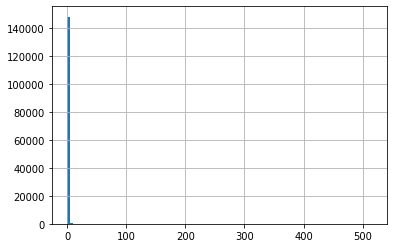

In [237]:
sorted_df['가구_수(가구)'].hist(bins=100)

In [238]:
max_df = sorted_df[sorted_df['가구_수(가구)'] == sorted_df['가구_수(가구)'].max()]
print(max_df.shape)

(2, 55)


In [240]:
sorted_df.drop(columns=['가구_수(가구)'], inplace=True)

In [241]:
sorted_df.head()

,대장_구분,대장_종류,대지_위치,번,지,외필지_수,동_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조,기타_구조,주_용도,기타_용도,지붕,기타_지붕,세대_수(세대),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관,허가번호_구분,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
0,집합,표제부,서울특별시 강남구 개포동 1163-4번지,1163,4,0,주건축물제1동,336.1,167.78,49.920000,1102.75,839.39,249.74,철근콘크리트구조,(벽식구조/철골조),공동주택,"도시형생활주택,종교시설",(철근)콘크리트,(철근)콘크리트,20,7,1,1,0,0,0.0,1102.75,0,0.0,0,0.0,9,138.00,0,0.0,20120113,20120227,20130307,2012,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20171118,서울특별시 강남구 개포동 1163-4,2017,주거용,주거용
1,집합,표제부,서울특별시 강남구 개포동 1163-4번지,1163,4,0,주건축물제1동,336.1,167.78,49.920000,1102.75,839.39,249.74,철근콘크리트구조,(벽식구조/철골조),종교시설,"도시형생활주택,종교시설",(철근)콘크리트,(철근)콘크리트,20,7,1,1,0,0,0.0,1102.75,0,0.0,0,0.0,9,138.00,0,0.0,20120113,20120227,20130307,2012,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20190813,서울특별시 강남구 개포동 1163-4,2019,비주거용,주거용
2,집합,표제부,서울특별시 강남구 개포동 1164번지,1164,0,0,NaN,325.5,185.07,56.860000,827.86,650.00,199.69,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택(도시형생활주택-단지형),(철근)콘크리트,(철근)콘크리트,10,5,1,1,0,0,0.0,827.86,0,0.0,0,0.0,8,120.77,0,0.0,20170315,20170321,20171107,2017,건축과,신축허가,1,NaN,0.0,79,NaN,0,NaN,0,20171219,서울특별시 강남구 개포동 1164-0,2017,주거용,주거용
3,집합,표제부,서울특별시 강남구 개포동 1164번지,1164,0,0,NaN,325.5,185.07,56.857142,827.86,650.00,199.69,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택(도시형생활주택-단지형),(철근)콘크리트,(철근)콘크리트,10,5,1,1,0,0,0.0,827.86,0,0.0,0,0.0,8,120.77,0,0.0,20170315,20170321,20171107,2017,건축과,신축허가,1,NaN,0.0,79,NaN,0,NaN,0,20181122,서울특별시 강남구 개포동 1164-0,2018,주거용,주거용
4,집합,표제부,서울특별시 강남구 개포동 1164-12번지,1164,12,0,NaN,330.3,166.01,50.260000,1360.02,1126.75,341.13,철근콘크리트구조,철근콘크리트조,공동주택,아파트,(철근)콘크리트,경사슬라브,12,7,1,0,0,0,0.0,1360.02,0,0.0,0,0.0,9,369.78,3,34.5,20000321,20000324,20000923,2000,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20190530,서울특별시 강남구 개포동 1164-12,2019,주거용,주거용


In [242]:
sorted_df.shape

(149344, 54)

In [243]:
sorted_df.drop_duplicates(inplace=True)
sorted_df.shape

(149344, 54)

In [244]:
sorted_df.head()

,대장_구분,대장_종류,대지_위치,번,지,외필지_수,동_명,대지_면적(㎡),건축_면적(㎡),건폐_율(%),연면적(㎡),용적_률_산정_연면적(㎡),용적_률(%),구조,기타_구조,주_용도,기타_용도,지붕,기타_지붕,세대_수(세대),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),총_동_연면적(㎡),옥내_기계식_대수(대),옥내_기계식_면적(㎡),옥외_기계식_대수(대),옥외_기계식_면적(㎡),옥내_자주식_대수(대),옥내_자주식_면적(㎡),옥외_자주식_대수(대),옥외_자주식_면적(㎡),허가_일,착공_일,사용승인_일,허가번호_년,허가번호_기관,허가번호_구분,호_수(호),에너지효율_등급,에너지절감_율,에너지_EPI점수,친환경_건축물_등급,친환경_건축물_인증점수,지능형_건축물_등급,지능형_건축물_인증점수,생성_일자,주소,생성년도,주용도_주거용여부,기타용도_주거용여부
0,집합,표제부,서울특별시 강남구 개포동 1163-4번지,1163,4,0,주건축물제1동,336.1,167.78,49.920000,1102.75,839.39,249.74,철근콘크리트구조,(벽식구조/철골조),공동주택,"도시형생활주택,종교시설",(철근)콘크리트,(철근)콘크리트,20,7,1,1,0,0,0.0,1102.75,0,0.0,0,0.0,9,138.00,0,0.0,20120113,20120227,20130307,2012,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20171118,서울특별시 강남구 개포동 1163-4,2017,주거용,주거용
1,집합,표제부,서울특별시 강남구 개포동 1163-4번지,1163,4,0,주건축물제1동,336.1,167.78,49.920000,1102.75,839.39,249.74,철근콘크리트구조,(벽식구조/철골조),종교시설,"도시형생활주택,종교시설",(철근)콘크리트,(철근)콘크리트,20,7,1,1,0,0,0.0,1102.75,0,0.0,0,0.0,9,138.00,0,0.0,20120113,20120227,20130307,2012,건축과,신축허가,0,NaN,0.0,0,NaN,0,NaN,0,20190813,서울특별시 강남구 개포동 1163-4,2019,비주거용,주거용
2,집합,표제부,서울특별시 강남구 개포동 1164번지,1164,0,0,NaN,325.5,185.07,56.860000,827.86,650.00,199.69,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택(도시형생활주택-단지형),(철근)콘크리트,(철근)콘크리트,10,5,1,1,0,0,0.0,827.86,0,0.0,0,0.0,8,120.77,0,0.0,20170315,20170321,20171107,2017,건축과,신축허가,1,NaN,0.0,79,NaN,0,NaN,0,20171219,서울특별시 강남구 개포동 1164-0,2017,주거용,주거용
3,집합,표제부,서울특별시 강남구 개포동 1164번지,1164,0,0,NaN,325.5,185.07,56.857142,827.86,650.00,199.69,철근콘크리트구조,철근콘크리트구조,공동주택,다세대주택(도시형생활주택-단지형),(철근)콘크리트,(철근)콘크리트,10,5,1,1,0,0,0.0,827.86,0,0.0,0,0.0,8,120.77,0,0.0,20170315,20170321,20171107,2017,건축과,신축허가,1,NaN,0.0,79,NaN,0,NaN,0,20181122,서울특별시 강남구 개포동 1164-0,2018,주거용,주거용
4,집합,표제부,서울특별시 강남구 개포동 1164-12번지,1164,12,0,NaN,330.3,166.01,50.260000,1360.02,1126.75,341.13,철근콘크리트구조,철근콘크리트조,공동주택,아파트,(철근)콘크리트,경사슬라브,12,7,1,0,0,0,0.0,1360.02,0,0.0,0,0.0,9,369.78,3,34.5,20000321,20000324,20000923,2000,NaN,NaN,0,NaN,0.0,0,NaN,0,NaN,0,20190530,서울특별시 강남구 개포동 1164-12,2019,주거용,주거용


In [245]:
sorted_df.to_csv(basedir + 'simple_sorted.csv', index=False)